# 2k布图第二版

In [65]:
import numpy as np  
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import seaborn as sns
from pandas.core.frame import DataFrame

from scipy.fftpack import fft,ifft
from tqdm import tqdm

from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

from matplotlib.ticker import Locator
from matplotlib.ticker import MaxNLocator

In [66]:
csv_filename = "printer.csv"

In [67]:
df = pd.read_csv(csv_filename)
df = df.drop('Unnamed: 0', axis = 1)
df.acc -= 1000
df.dropna()  # eliminate rows with null value
if df[df.isnull().values == True].size != 0:
    raise SyntaxError('NullData')
df.head(10)

,timestamp,us,acc,ang,label
0,52:08.4,1012464,35.9847,2.278444,0
1,52:08.4,1044468,33.4202,2.238483,0
2,52:08.4,1076472,38.2080,2.439916,0
3,52:08.5,1108476,37.0320,2.406370,0
4,52:08.5,1140476,38.3076,2.153828,0
5,52:08.5,1172476,37.0735,2.200191,0
6,52:08.6,1204472,37.3519,2.406599,0
7,52:08.6,1236472,38.3412,2.569589,0
8,52:08.7,1268480,31.3844,2.370398,0
9,52:08.7,1300492,38.4645,2.316197,0


In [82]:
acc_list = np.array(df["acc"])
acc_time = np.array(df["timestamp"])
acc_us = np.array(df["us"])
acc_ms = [int(ms) for ms in acc_us/1000]
acc_list = acc_list
acc_mean = np.mean(acc_list)
acc_std  = np.std(acc_list)
acc_mean_str = "{:.2f}".format(acc_mean)
acc_std_str = "{:.2f}".format(acc_std)
print("the acc dist mean:%.2fmg and std:%.2fmg" %(acc_mean,acc_std))
print(acc_ms,len(acc_ms),len(df))

the acc dist mean:37.96mg and std:11.93mg
[1012, 1044, 1076, 1108, 1140, 1172, 1204, 1236, 1268, 1300, 1332, 1364, 1396, 1428, 1460, 1492, 1524, 1556, 1588, 1620, 1652, 1684, 1716, 1748, 1780, 1812, 1844, 1876, 1908, 1940, 1972, 2004, 2036, 2068, 2100, 2132, 2164, 2196, 2228, 2260, 2292, 2324, 2356, 2388, 2420, 2452, 2484, 2516, 2548, 2580, 2612, 2644, 2676, 2708, 2740, 2772, 2804, 2836, 2868, 2900, 2932, 2964, 2996, 3028, 3060, 3092, 3124, 3156, 3188, 3220, 3252, 3284, 3316, 3348, 3380, 3412, 3444, 3476, 3508, 3540, 3572, 3604, 3636, 3668, 3700, 3732, 3764, 3796, 3828, 3860, 3892, 3924, 3956, 3988, 4020, 4052, 4084, 4116, 4148, 4180, 4212, 4244, 4276, 4308, 4340, 4372, 4404, 4436, 4468, 4500, 4532, 4564, 4596, 4628, 4660, 4692, 4724, 4756, 4788, 4820, 4852, 4884, 4916, 4948, 4980, 5012, 5044, 5076, 5108, 5140, 5172, 5204, 5236, 5268, 5300, 5332, 5364, 5396, 5428, 5460, 5492, 5524, 5556, 5588, 5620, 5652, 5684, 5716, 5748, 5780, 5812, 5844, 5876, 5908, 5940, 5972, 6004, 6036, 6068, 610

# 加速度传感器矫正





  0%|          | 0/7164 [00:00<?, ?it/s]



 26%|██▋       | 1898/7164 [00:00<00:00, 18977.17it/s]



 46%|████▋     | 3331/7164 [00:00<00:00, 17292.53it/s]



 68%|██████▊   | 4862/7164 [00:00<00:00, 16644.95it/s]



 91%|█████████▏| 6550/7164 [00:00<00:00, 16712.59it/s]



100%|██████████| 7164/7164 [00:00<00:00, 15947.11it/s]

37.355357957139475

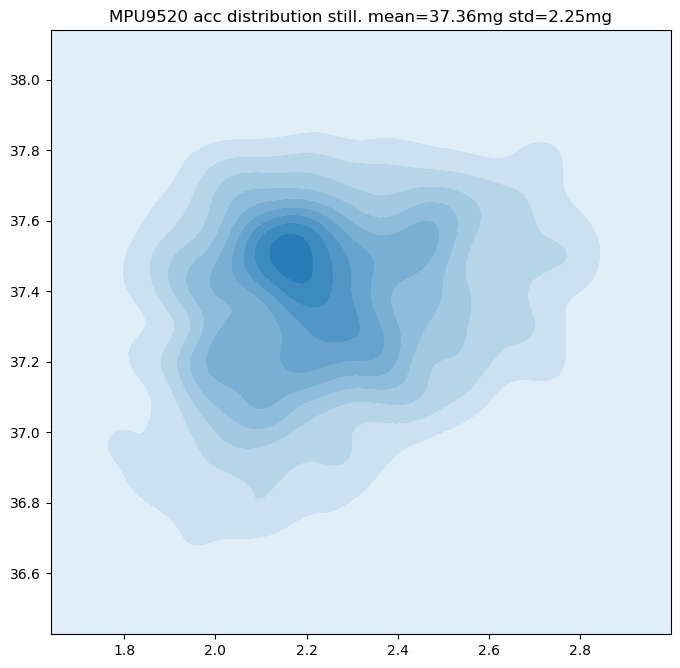

In [83]:
# 加速度传感器校准用
CONST_STATIC_WINDOW = 64
static_mean_list = []
static_std_list  = []
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(CONST_STATIC_WINDOW,acc_list.size,1)):
    acc_list_slice = acc_list[k-CONST_STATIC_WINDOW:k]
    acc_mean = np.mean(acc_list_slice)
    acc_std  = np.std(acc_list_slice)
    if acc_std < 3:
        static_std_list.append(acc_std)
        static_mean_list.append(acc_mean)
pass
static_mean = np.mean(static_mean_list)
static_std = np.mean(static_std_list)
static_mean_str = "{:.2f}".format(static_mean)
static_std_str = "{:.2f}".format(static_std)
# print(static_std_list)
bins=np.arange(np.min(static_std_list),np.max(static_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(static_std_list), np.max(static_std_list))
sns.kdeplot(static_std_list,static_mean_list,shade=True)
plt.title("MPU9520 acc distribution still. mean="+static_mean_str+"mg std="+static_std_str+"mg")
plt.savefig("static.png")
static_mean

In [84]:
acc_list = acc_list - static_mean # 将加速度列表矫正到0
len(acc_list)

7228

# 以秒为单位计算std和avg，找出最大的以判断时域波形刻度范围





  0%|          | 0/225 [00:00<?, ?it/s]



100%|██████████| 225/225 [00:00<00:00, 6612.01it/s]

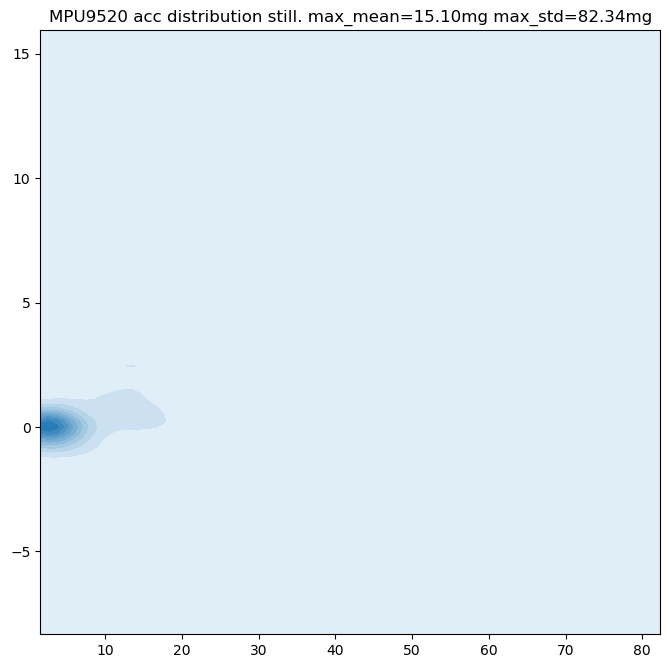

In [85]:
SECOND_WINDOW = 32# sample rate 32
second_mean_list = []
second_std_list  = []
acc_mean_max = float()
acc_std_max = float()
#遍历加速度，寻找传感器安静的时间段，记录它的avg和std
for k in tqdm(range(SECOND_WINDOW,acc_list.size,SECOND_WINDOW)):
    acc_list_slice = acc_list[k-SECOND_WINDOW:k-1]
    acc_mean_max = acc_mean_max if(acc_mean_max>np.mean(acc_list_slice)) else np.mean(acc_list_slice)
    acc_std_max  = acc_std_max if(acc_std_max>np.std(acc_list_slice)) else np.std(acc_list_slice)
    second_mean_list.append(np.mean(acc_list_slice))
    second_std_list.append(np.std(acc_list_slice))
pass

acc_mean_str = "{:.2f}".format(acc_mean_max)
acc_std_str = "{:.2f}".format(acc_std_max)
# print(static_std_list)
bins=np.arange(np.min(second_std_list),np.max(second_std_list),0.1)
plt.figure(figsize=(8, 8), dpi=100)
ax = plt.subplot()
ax.set_xlim(np.min(second_std_list), np.max(second_std_list))
sns.kdeplot(second_std_list,second_mean_list,shade=True)
plt.title("MPU9520 acc distribution still. max_mean="+acc_mean_str+"mg max_std="+acc_std_str+"mg")
plt.savefig("max_mean__max_std.png")

# 以1024个点为单位遍历一次，找FFT的直流分量大小

In [77]:
FFT = list()
for i in range(0,len(acc_list)):
#     if FFT_0<np.mean(acc_list[i:i+32]):
    FFT.append(np.mean(acc_list[i:i+1024]))
#     print(np.mean(acc_list[i:i+32]),i)
np.mean(FFT)

0.6017691696814182

# 开始画图

In [78]:
fig= Figure(figsize=[25.6,14.4],dpi=100,facecolor="black",edgecolor="#BEBEBE")
canvas = FigureCanvas(fig)
ax_chart = fig.add_axes([100/2560,970/1440,1757/2560,420/1440])
ax_FFT_low = fig.add_axes([1003/2560,510/1440,853/2560,412/1440])
ax_FFT_high = fig.add_axes([100/2560,510/1440,853/2560,412/1440])
ax_violins = fig.add_axes([100/2560,30/1440,1550/2560,426/1440])
ax_violin = fig.add_axes([1700/2560,30/1440,760/2560,426/1440])
ax_video = fig.add_axes([1907/2560,496/1440,531/2560,944/1440])
canvas.print_figure("123.png")
fig.savefig("sample.png",facecolor=fig.get_facecolor(),edgecolor=fig.get_edgecolor())

# 使用seaborn画violin

In [86]:
#plt.savefig("sample.png")
CONST_ACC_MAX = math.pow(2, int(math.log(acc_mean_max + 4 * acc_std_max, 2)) + 1)
# define the limits automatically
CONST_ACC_MIN = -CONST_ACC_MAX
CONST_CHART_WINDOW = 1024
CONST_FFT_WINDOW = 1024
CONST_VIOLIN_WINDOW = 32
CONST_VIOLINS_WINDOW = 1024
CONST_VIOLINS_DIV = 32
CONST_SAMP_RATE = 32  # 采样率
CONST_COLOR_STD_LMT = 128
CONST_BLUE_RGB = [0, 0, 255]
CONST_WHITE_RGB = [255, 255, 255]
CONST_FFT_MIN = 0
CONST_FFT_MAX = 2

def whiten(ax, title):
    spine = ['bottom', 'top', 'right', 'left']
    for tickline in ax.xaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.xaxis.get_ticklabels():
        ticklabel.set_color('white')
    for tickline in ax.yaxis.get_ticklines():
        tickline.set_color('white')
    for ticklabel in ax.yaxis.get_ticklabels():
        ticklabel.set_color('white')
    for orien in spine:
        ax.spines[orien].set_color('black')
    ax.set_facecolor("black")  # grey
    title.set_color("white")
    title.set_fontsize('large')


def whiten_violin(result):
    for key in result:
        if key is not 'bodies':
            result[key].set_color('')

for k in tqdm(range( acc_list.size)):  # start form 1024, shift 8 every time
    #list.index()
    ax_violin.set_xlim(CONST_ACC_MIN, CONST_ACC_MAX)
    ax_violins.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)
    ax_chart.set_ylim(CONST_ACC_MIN, CONST_ACC_MAX)

    # 绘制时域图
    slice_start = k - CONST_FFT_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_CHART_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    ax_chart.plot(acc_slice, '--w')  # '--w'
    title = ax_chart.set_title(
        "Realtime chart,Time: " + str(acc_time[k]) + "  Reading: " + "{:.2f}".format(acc_list[k]) + "mg")
    whiten(ax_chart, title)

    # 绘制FFT图
    #########################################
    #     slice_start = k - CONST_FFT_WINDOW
    #     slice_end = k
    #     if slice_start < 0:
    #         slice_start = 0
    #     acc_slice = acc_list[slice_start:slice_end]
    #     acc_slice = np.lib.pad(acc_slice,(CONST_CHART_WINDOW-acc_slice.size,0),'constant', constant_values=(0,0))
    fft_abs = abs(fft(acc_slice))
    fft_norm = fft_abs / int(CONST_FFT_WINDOW)
    fft_half = fft_norm[:int(CONST_FFT_WINDOW / 2)]

    # LOW ####################
    ax_FFT_low.bar(x=np.linspace(0, CONST_SAMP_RATE / 8, 129)[:-1],  # the first 128 points covers frequency from 0-4hz
                   height=fft_half[0:128],
                   width=0.9,
                   bottom=0,
                   align="center",
                   color="white")

    ax_FFT_low.xaxis.set_major_locator(MaxNLocator(nbins=20, prune='lower'))
    title = ax_FFT_low.set_title("FFT low:0-4Hz")
    whiten(ax_FFT_low, title)
    ax_FFT_low.set_ylim(CONST_FFT_MIN, CONST_FFT_MAX)
    ax_FFT_low.set_xlim(0, 4)  # 0-4hz

    # HIGH ###################
    fft_high_list = []  # length = 512/4
    fft_high_list_element = float()
    for p in range(0, fft_half.size + 1, 4)[1:]:
        for slice_element in fft_half[p - 4:p]:
            fft_high_list_element += slice_element
        fft_high_list.append(fft_high_list_element)
        fft_high_list_element = 0

    ax_FFT_high.bar(x=np.linspace(0, CONST_SAMP_RATE / 2, 129)[:-1],  # the first 128 points covers frequency from 0-4hz
                    height=fft_high_list,
                    width=0.9,
                    bottom=0,
                    color="white"
                    )

    ax_FFT_high.xaxis.set_major_locator(MaxNLocator(nbins=20, prune='lower'))
    title = ax_FFT_high.set_title("FFT high:0-16Hz")
    whiten(ax_FFT_high, title)
    ax_FFT_high.set_ylim(CONST_FFT_MIN, CONST_FFT_MAX)

    # 绘制violin图
    ##########################################
    slice_start = k - CONST_VIOLIN_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_VIOLIN_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))
    acc_slice_dataset = pd.DataFrame(acc_slice)
    violin_mean = acc_slice_dataset[0].mean()
    violin_std = acc_slice_dataset[0].std()
    violin_mean_str = "{:.5f}".format(violin_mean)
    violin_std_str = "{:.5f}".format(violin_std)

    #     violin_result = ax_violin.violinplot(dataset=acc_slice,vert=False,widths=0.6
    # #                                          ,showmeans=True,showextrema=True,showmedians=True
    #                          )
    face_color = [
        (CONST_WHITE_RGB[i] - (CONST_WHITE_RGB[i] - CONST_BLUE_RGB[i]) * abs(violin_std / CONST_COLOR_STD_LMT)) / 255
        for i in range(3)]
    #     print(face_color)
    ###########seaborn violin#############
    violinplot_ax = sns.violinplot(x=acc_slice, color=face_color, ax=ax_violin, linewidth=0)
    ax.grid(False)
    ax_violin.xaxis.set_major_locator(MaxNLocator(nbins=(CONST_ACC_MAX / 4) + 1, prune='lower'))

    #     for pc in violin_result["bodies"]:
    #         pc.set_facecolor(face_color)
    #         pc.set_edgecolor('white')
    #         pc.set_alpha(1)
    title = ax_violin.set_title("Realtime violin. Mean: " + violin_mean_str + "  Std: " + violin_std_str)
    whiten(ax_violin, title)
    #     whiten_violin(violin_result)

    # 绘制violins图
    ################################
    slice_start = k - CONST_VIOLINS_WINDOW
    slice_end = k
    if slice_start < 0:
        slice_start = 0
    acc_slice = acc_list[slice_start:slice_end]
    acc_slice = np.lib.pad(acc_slice, (CONST_VIOLINS_WINDOW - acc_slice.size, 0), 'constant', constant_values=(0, 0))

    #     violins_list = []
    #     for t in np.linspace(0,CONST_VIOLINS_WINDOW-1,32)[1:]:# remove the first element zero
    #         violin_slice = acc_slice[t-32:t]
    #         violins_list.append(int(t/32))

    violins_dataset = pd.DataFrame(
        [acc_slice[int(t - CONST_VIOLINS_DIV):int(t)] for t in list(np.linspace(0, 1024, CONST_VIOLINS_DIV + 1)[1:])])
    #     print(violins_dataset.loc[31,:].mean())
    color_list = []
    for row in range(CONST_VIOLINS_DIV):
        violins_color = abs(violins_dataset.loc[row, :].std())
        violins_color_relative = violins_color / CONST_COLOR_STD_LMT
        color_list.append(
            [(CONST_WHITE_RGB[i] - (CONST_WHITE_RGB[i] - CONST_BLUE_RGB[i]) * violins_color_relative) / 255 for i in
             range(3)])
        # rgba in float 0-1 form
    violins_result = ax_violins.violinplot(dataset=violins_dataset
                                           #                                            ,showmeans=True,showextrema=True,showmedians=True
                                           )
    ax_violins.yaxis.set_major_locator(MaxNLocator(nbins=(CONST_ACC_MAX / 4) + 1, prune='lower'))
    #     print(color_list)
    for pc in violins_result['bodies']:
        pc.set_facecolor(color_list)
        pc.set_edgecolor('white')
        pc.set_alpha(1)

    title = ax_violins.set_title("History violins")
    whiten(ax_violins, title)
    whiten_violin(violins_result)

    # 调整 video框
    ax_video.set_facecolor("black")
    spine = ['bottom', 'top', 'right', 'left']
    for orien in spine:
        ax_video.spines[orien].set_color('white')
    ax_video.axis(option=False)

    # save figs
    fig.savefig(str(10000000000 + acc_ms[k]) + '.png', facecolor=fig.get_facecolor(), edgecolor='none')
    ax_chart.cla()
    ax_FFT_low.cla()
    ax_FFT_high.cla()
    ax_violin.cla()
    ax_violins.cla()
    # if k==20:
    #     break





  0%|          | 0/7228 [00:00<?, ?it/s]



  0%|          | 1/7228 [00:01<2:20:55,  1.17s/it]



  0%|          | 2/7228 [00:02<2:24:15,  1.20s/it]



  0%|          | 3/7228 [00:03<2:22:27,  1.18s/it]



  0%|          | 4/7228 [00:04<2:22:14,  1.18s/it]



  0%|          | 5/7228 [00:06<2:28:04,  1.23s/it]



  0%|          | 6/7228 [00:07<2:41:09,  1.34s/it]



  0%|          | 7/7228 [00:08<2:39:25,  1.32s/it]



  0%|          | 8/7228 [00:10<2:45:11,  1.37s/it]



  0%|          | 9/7228 [00:12<3:12:47,  1.60s/it]



  0%|          | 10/7228 [00:13<2:57:31,  1.48s/it]



  0%|          | 11/7228 [00:15<2:52:57,  1.44s/it]



  0%|          | 12/7228 [00:16<2:45:53,  1.38s/it]



  0%|          | 13/7228 [00:17<2:42:40,  1.35s/it]



  0%|          | 14/7228 [00:18<2:33:37,  1.28s/it]



  0%|          | 15/7228 [00:20<2:32:57,  1.27s/it]



  0%|          | 16/7228 [00:21<2:29:30,  1.24s/it]



  0%|          | 17/7228 [00:22<2:30:45,  1.25s/it]



  0%|          | 18/7228 [

  2%|▏         | 122/7228 [02:37<2:23:51,  1.21s/it]



  2%|▏         | 123/7228 [02:38<2:27:32,  1.25s/it]



  2%|▏         | 124/7228 [02:40<2:28:02,  1.25s/it]



  2%|▏         | 125/7228 [02:41<2:26:16,  1.24s/it]



  2%|▏         | 126/7228 [02:42<2:23:23,  1.21s/it]



  2%|▏         | 127/7228 [02:43<2:31:14,  1.28s/it]



  2%|▏         | 128/7228 [02:44<2:26:28,  1.24s/it]



  2%|▏         | 129/7228 [02:46<2:24:36,  1.22s/it]



  2%|▏         | 130/7228 [02:47<2:21:57,  1.20s/it]



  2%|▏         | 131/7228 [02:48<2:32:49,  1.29s/it]



  2%|▏         | 132/7228 [02:50<2:29:26,  1.26s/it]



  2%|▏         | 133/7228 [02:51<2:25:32,  1.23s/it]



  2%|▏         | 134/7228 [02:52<2:24:41,  1.22s/it]



  2%|▏         | 135/7228 [02:53<2:29:23,  1.26s/it]



  2%|▏         | 136/7228 [02:54<2:28:09,  1.25s/it]



  2%|▏         | 137/7228 [02:56<2:24:28,  1.22s/it]



  2%|▏         | 138/7228 [02:57<2:23:41,  1.22s/it]



  2%|▏         | 139/7228 [02:58<2:36:05,  1.32s

  3%|▎         | 242/7228 [05:17<2:07:46,  1.10s/it]



  3%|▎         | 243/7228 [05:18<2:10:25,  1.12s/it]



  3%|▎         | 244/7228 [05:19<2:12:41,  1.14s/it]



  3%|▎         | 245/7228 [05:20<2:12:11,  1.14s/it]



  3%|▎         | 246/7228 [05:21<2:10:52,  1.12s/it]



  3%|▎         | 247/7228 [05:23<2:11:16,  1.13s/it]



  3%|▎         | 248/7228 [25:25<700:58:24, 361.53s/it]



  3%|▎         | 249/7228 [25:26<491:17:21, 253.42s/it]



  3%|▎         | 250/7228 [25:27<344:32:02, 177.75s/it]



  3%|▎         | 251/7228 [25:29<241:54:10, 124.82s/it]



  3%|▎         | 252/7228 [25:30<170:04:14, 87.77s/it] 



  4%|▎         | 253/7228 [25:31<119:45:35, 61.81s/it]



  4%|▎         | 254/7228 [25:32<84:30:34, 43.62s/it] 



  4%|▎         | 255/7228 [25:34<59:48:59, 30.88s/it]



  4%|▎         | 256/7228 [25:45<48:15:02, 24.91s/it]



  4%|▎         | 257/7228 [25:48<35:33:06, 18.36s/it]



  4%|▎         | 258/7228 [25:49<25:30:49, 13.18s/it]



  4%|▎         | 259/7228

  5%|▍         | 361/7228 [31:38<2:43:43,  1.43s/it]



  5%|▌         | 362/7228 [31:39<2:42:43,  1.42s/it]



  5%|▌         | 363/7228 [31:40<2:36:57,  1.37s/it]



  5%|▌         | 364/7228 [31:42<2:40:57,  1.41s/it]



  5%|▌         | 365/7228 [31:43<2:41:51,  1.42s/it]



  5%|▌         | 366/7228 [31:45<2:38:25,  1.39s/it]



  5%|▌         | 367/7228 [31:46<2:40:10,  1.40s/it]



  5%|▌         | 368/7228 [31:48<2:42:45,  1.42s/it]



  5%|▌         | 369/7228 [31:49<2:37:08,  1.37s/it]



  5%|▌         | 370/7228 [31:50<2:37:41,  1.38s/it]



  5%|▌         | 371/7228 [31:52<2:45:15,  1.45s/it]



  5%|▌         | 372/7228 [31:53<2:41:39,  1.41s/it]



  5%|▌         | 373/7228 [31:55<2:40:49,  1.41s/it]



  5%|▌         | 374/7228 [31:56<2:41:27,  1.41s/it]



  5%|▌         | 375/7228 [31:58<2:46:58,  1.46s/it]



  5%|▌         | 376/7228 [31:59<2:43:20,  1.43s/it]



  5%|▌         | 377/7228 [32:00<2:36:34,  1.37s/it]



  5%|▌         | 378/7228 [32:02<2:47:59,  1.47s

  7%|▋         | 481/7228 [34:29<2:31:16,  1.35s/it]



  7%|▋         | 482/7228 [34:30<2:27:25,  1.31s/it]



  7%|▋         | 483/7228 [34:32<2:18:40,  1.23s/it]



  7%|▋         | 484/7228 [34:33<2:16:47,  1.22s/it]



  7%|▋         | 485/7228 [34:34<2:21:55,  1.26s/it]



  7%|▋         | 486/7228 [34:35<2:15:06,  1.20s/it]



  7%|▋         | 487/7228 [34:36<2:13:29,  1.19s/it]



  7%|▋         | 488/7228 [34:38<2:21:31,  1.26s/it]



  7%|▋         | 489/7228 [34:39<2:32:48,  1.36s/it]



  7%|▋         | 490/7228 [34:41<2:28:47,  1.32s/it]



  7%|▋         | 491/7228 [34:42<2:33:43,  1.37s/it]



  7%|▋         | 492/7228 [34:44<2:40:16,  1.43s/it]



  7%|▋         | 493/7228 [34:45<2:39:38,  1.42s/it]



  7%|▋         | 494/7228 [34:46<2:36:51,  1.40s/it]



  7%|▋         | 495/7228 [34:48<2:40:57,  1.43s/it]



  7%|▋         | 496/7228 [34:49<2:40:45,  1.43s/it]



  7%|▋         | 497/7228 [34:51<2:37:22,  1.40s/it]



  7%|▋         | 498/7228 [34:52<2:37:41,  1.41s

  8%|▊         | 601/7228 [37:20<2:28:30,  1.34s/it]



  8%|▊         | 602/7228 [37:21<2:26:40,  1.33s/it]



  8%|▊         | 603/7228 [37:22<2:26:14,  1.32s/it]



  8%|▊         | 604/7228 [37:24<2:26:51,  1.33s/it]



  8%|▊         | 605/7228 [37:25<2:39:52,  1.45s/it]



  8%|▊         | 606/7228 [37:27<2:45:58,  1.50s/it]



  8%|▊         | 607/7228 [37:29<2:46:31,  1.51s/it]



  8%|▊         | 608/7228 [37:31<3:03:40,  1.66s/it]



  8%|▊         | 609/7228 [37:32<2:54:48,  1.58s/it]



  8%|▊         | 610/7228 [37:34<2:55:53,  1.59s/it]



  8%|▊         | 611/7228 [37:35<3:00:10,  1.63s/it]



  8%|▊         | 612/7228 [37:39<4:05:23,  2.23s/it]



  8%|▊         | 613/7228 [37:42<4:39:19,  2.53s/it]



  8%|▊         | 614/7228 [37:44<4:07:13,  2.24s/it]



  9%|▊         | 615/7228 [37:45<3:46:29,  2.05s/it]



  9%|▊         | 616/7228 [37:47<3:27:56,  1.89s/it]



  9%|▊         | 617/7228 [37:49<3:41:21,  2.01s/it]



  9%|▊         | 618/7228 [37:50<3:19:33,  1.81s

 10%|▉         | 721/7228 [40:32<2:47:39,  1.55s/it]



 10%|▉         | 722/7228 [40:34<2:57:01,  1.63s/it]



 10%|█         | 723/7228 [40:36<2:49:29,  1.56s/it]



 10%|█         | 724/7228 [40:37<2:44:27,  1.52s/it]



 10%|█         | 725/7228 [40:39<2:53:20,  1.60s/it]



 10%|█         | 726/7228 [40:40<2:51:15,  1.58s/it]



 10%|█         | 727/7228 [40:42<2:41:21,  1.49s/it]



 10%|█         | 728/7228 [40:43<2:45:47,  1.53s/it]



 10%|█         | 729/7228 [40:45<2:49:39,  1.57s/it]



 10%|█         | 730/7228 [40:46<2:41:41,  1.49s/it]



 10%|█         | 731/7228 [40:48<2:44:37,  1.52s/it]



 10%|█         | 732/7228 [40:49<2:48:11,  1.55s/it]



 10%|█         | 733/7228 [40:51<2:45:15,  1.53s/it]



 10%|█         | 734/7228 [40:52<2:45:03,  1.53s/it]



 10%|█         | 735/7228 [40:54<2:48:46,  1.56s/it]



 10%|█         | 736/7228 [40:56<2:50:18,  1.57s/it]



 10%|█         | 737/7228 [40:57<2:44:53,  1.52s/it]



 10%|█         | 738/7228 [40:59<2:54:57,  1.62s

 12%|█▏        | 841/7228 [43:49<3:37:40,  2.04s/it]



 12%|█▏        | 842/7228 [43:51<3:23:27,  1.91s/it]



 12%|█▏        | 843/7228 [43:52<3:06:59,  1.76s/it]



 12%|█▏        | 844/7228 [43:54<3:03:06,  1.72s/it]



 12%|█▏        | 845/7228 [43:56<3:05:39,  1.75s/it]



 12%|█▏        | 846/7228 [43:57<2:50:22,  1.60s/it]



 12%|█▏        | 847/7228 [43:58<2:52:10,  1.62s/it]



 12%|█▏        | 848/7228 [44:00<2:58:18,  1.68s/it]



 12%|█▏        | 849/7228 [44:02<2:49:33,  1.59s/it]



 12%|█▏        | 850/7228 [44:03<2:50:35,  1.60s/it]



 12%|█▏        | 851/7228 [44:05<2:50:00,  1.60s/it]



 12%|█▏        | 852/7228 [44:06<2:46:31,  1.57s/it]



 12%|█▏        | 853/7228 [44:08<2:43:46,  1.54s/it]



 12%|█▏        | 854/7228 [44:10<2:51:01,  1.61s/it]



 12%|█▏        | 855/7228 [44:11<2:50:24,  1.60s/it]



 12%|█▏        | 856/7228 [44:12<2:40:08,  1.51s/it]



 12%|█▏        | 857/7228 [44:14<2:49:18,  1.59s/it]



 12%|█▏        | 858/7228 [44:16<2:50:04,  1.60s

 13%|█▎        | 961/7228 [47:03<2:57:39,  1.70s/it]



 13%|█▎        | 962/7228 [47:04<3:00:16,  1.73s/it]



 13%|█▎        | 963/7228 [47:06<3:02:56,  1.75s/it]



 13%|█▎        | 964/7228 [47:08<2:57:24,  1.70s/it]



 13%|█▎        | 965/7228 [47:10<2:58:45,  1.71s/it]



 13%|█▎        | 966/7228 [47:11<3:03:52,  1.76s/it]



 13%|█▎        | 967/7228 [47:13<2:51:03,  1.64s/it]



 13%|█▎        | 968/7228 [47:14<2:53:58,  1.67s/it]



 13%|█▎        | 969/7228 [47:16<2:57:58,  1.71s/it]



 13%|█▎        | 970/7228 [47:18<2:53:01,  1.66s/it]



 13%|█▎        | 971/7228 [47:20<2:58:00,  1.71s/it]



 13%|█▎        | 972/7228 [47:21<2:58:33,  1.71s/it]



 13%|█▎        | 973/7228 [47:23<2:51:59,  1.65s/it]



 13%|█▎        | 974/7228 [47:25<2:58:04,  1.71s/it]



 13%|█▎        | 975/7228 [47:26<2:58:39,  1.71s/it]



 14%|█▎        | 976/7228 [47:28<2:47:16,  1.61s/it]



 14%|█▎        | 977/7228 [47:30<2:52:21,  1.65s/it]



 14%|█▎        | 978/7228 [47:31<2:59:48,  1.73s

 15%|█▍        | 1080/7228 [50:28<2:53:13,  1.69s/it]



 15%|█▍        | 1081/7228 [50:30<2:55:19,  1.71s/it]



 15%|█▍        | 1082/7228 [50:32<2:59:37,  1.75s/it]



 15%|█▍        | 1083/7228 [50:33<2:53:05,  1.69s/it]



 15%|█▍        | 1084/7228 [50:35<2:55:30,  1.71s/it]



 15%|█▌        | 1085/7228 [50:37<3:03:29,  1.79s/it]



 15%|█▌        | 1086/7228 [50:39<2:55:38,  1.72s/it]



 15%|█▌        | 1087/7228 [50:40<2:57:17,  1.73s/it]



 15%|█▌        | 1088/7228 [50:42<2:57:27,  1.73s/it]



 15%|█▌        | 1089/7228 [50:44<2:53:22,  1.69s/it]



 15%|█▌        | 1090/7228 [50:46<2:57:06,  1.73s/it]



 15%|█▌        | 1091/7228 [50:47<2:57:13,  1.73s/it]



 15%|█▌        | 1092/7228 [50:49<2:48:07,  1.64s/it]



 15%|█▌        | 1093/7228 [50:51<2:52:11,  1.68s/it]



 15%|█▌        | 1094/7228 [50:52<2:56:16,  1.72s/it]



 15%|█▌        | 1095/7228 [50:54<2:54:03,  1.70s/it]



 15%|█▌        | 1096/7228 [50:56<2:56:30,  1.73s/it]



 15%|█▌        | 1097/7228 [50:

 17%|█▋        | 1198/7228 [53:44<3:03:14,  1.82s/it]



 17%|█▋        | 1199/7228 [53:46<3:03:37,  1.83s/it]



 17%|█▋        | 1200/7228 [53:47<3:00:25,  1.80s/it]



 17%|█▋        | 1201/7228 [53:49<3:03:16,  1.82s/it]



 17%|█▋        | 1202/7228 [53:51<3:01:04,  1.80s/it]



 17%|█▋        | 1203/7228 [53:53<3:05:48,  1.85s/it]



 17%|█▋        | 1204/7228 [53:55<3:04:14,  1.84s/it]



 17%|█▋        | 1205/7228 [53:57<3:02:26,  1.82s/it]



 17%|█▋        | 1206/7228 [53:58<3:03:13,  1.83s/it]



 17%|█▋        | 1207/7228 [54:00<2:59:17,  1.79s/it]



 17%|█▋        | 1208/7228 [54:02<3:05:36,  1.85s/it]



 17%|█▋        | 1209/7228 [54:04<3:00:46,  1.80s/it]



 17%|█▋        | 1210/7228 [54:06<3:03:31,  1.83s/it]



 17%|█▋        | 1211/7228 [54:08<3:04:39,  1.84s/it]



 17%|█▋        | 1212/7228 [54:09<2:53:10,  1.73s/it]



 17%|█▋        | 1213/7228 [54:11<3:00:46,  1.80s/it]



 17%|█▋        | 1214/7228 [54:13<2:56:58,  1.77s/it]



 17%|█▋        | 1215/7228 [54:

 18%|█▊        | 1316/7228 [57:12<2:45:30,  1.68s/it]



 18%|█▊        | 1317/7228 [57:14<2:43:08,  1.66s/it]



 18%|█▊        | 1318/7228 [57:15<2:40:01,  1.62s/it]



 18%|█▊        | 1319/7228 [57:17<2:43:33,  1.66s/it]



 18%|█▊        | 1320/7228 [57:19<2:44:54,  1.67s/it]



 18%|█▊        | 1321/7228 [57:20<2:44:53,  1.67s/it]



 18%|█▊        | 1322/7228 [57:22<2:48:36,  1.71s/it]



 18%|█▊        | 1323/7228 [57:24<2:46:31,  1.69s/it]



 18%|█▊        | 1324/7228 [57:26<2:51:11,  1.74s/it]



 18%|█▊        | 1325/7228 [57:27<2:49:21,  1.72s/it]



 18%|█▊        | 1326/7228 [57:29<2:49:54,  1.73s/it]



 18%|█▊        | 1327/7228 [57:31<2:51:10,  1.74s/it]



 18%|█▊        | 1328/7228 [57:32<2:45:08,  1.68s/it]



 18%|█▊        | 1329/7228 [57:34<2:47:09,  1.70s/it]



 18%|█▊        | 1330/7228 [57:36<2:48:56,  1.72s/it]



 18%|█▊        | 1331/7228 [57:38<2:49:14,  1.72s/it]



 18%|█▊        | 1332/7228 [57:39<2:47:14,  1.70s/it]



 18%|█▊        | 1333/7228 [57:

 20%|█▉        | 1434/7228 [1:00:35<2:41:51,  1.68s/it]



 20%|█▉        | 1435/7228 [1:00:37<2:47:28,  1.73s/it]



 20%|█▉        | 1436/7228 [1:00:39<2:46:13,  1.72s/it]



 20%|█▉        | 1437/7228 [1:00:40<2:41:34,  1.67s/it]



 20%|█▉        | 1438/7228 [1:00:42<2:47:41,  1.74s/it]



 20%|█▉        | 1439/7228 [1:00:44<2:47:55,  1.74s/it]



 20%|█▉        | 1440/7228 [1:00:45<2:44:44,  1.71s/it]



 20%|█▉        | 1441/7228 [1:00:47<2:44:16,  1.70s/it]



 20%|█▉        | 1442/7228 [1:00:49<2:42:48,  1.69s/it]



 20%|█▉        | 1443/7228 [1:00:50<2:42:54,  1.69s/it]



 20%|█▉        | 1444/7228 [1:00:52<2:39:16,  1.65s/it]



 20%|█▉        | 1445/7228 [1:00:54<2:40:48,  1.67s/it]



 20%|██        | 1446/7228 [1:00:56<2:45:05,  1.71s/it]



 20%|██        | 1447/7228 [1:00:57<2:45:14,  1.72s/it]



 20%|██        | 1448/7228 [1:00:59<2:44:13,  1.70s/it]



 20%|██        | 1449/7228 [1:01:01<2:41:13,  1.67s/it]



 20%|██        | 1450/7228 [1:01:02<2:42:11,  1.68s/it]


 21%|██▏       | 1549/7228 [1:03:43<2:40:13,  1.69s/it]



 21%|██▏       | 1550/7228 [1:03:45<2:41:11,  1.70s/it]



 21%|██▏       | 1551/7228 [1:03:47<2:35:27,  1.64s/it]



 21%|██▏       | 1552/7228 [1:03:48<2:42:42,  1.72s/it]



 21%|██▏       | 1553/7228 [1:03:50<2:42:16,  1.72s/it]



 21%|██▏       | 1554/7228 [1:03:52<2:44:09,  1.74s/it]



 22%|██▏       | 1555/7228 [1:03:54<2:42:17,  1.72s/it]



 22%|██▏       | 1556/7228 [1:03:55<2:37:41,  1.67s/it]



 22%|██▏       | 1557/7228 [1:03:57<2:47:30,  1.77s/it]



 22%|██▏       | 1558/7228 [1:03:59<2:46:26,  1.76s/it]



 22%|██▏       | 1559/7228 [1:04:01<2:48:00,  1.78s/it]



 22%|██▏       | 1560/7228 [1:04:02<2:44:46,  1.74s/it]



 22%|██▏       | 1561/7228 [1:04:04<2:42:37,  1.72s/it]



 22%|██▏       | 1562/7228 [1:04:06<2:40:40,  1.70s/it]



 22%|██▏       | 1563/7228 [1:04:07<2:41:20,  1.71s/it]



 22%|██▏       | 1564/7228 [1:04:09<2:41:16,  1.71s/it]



 22%|██▏       | 1565/7228 [1:04:11<2:39:07,  1.69s/it]


 23%|██▎       | 1664/7228 [1:06:54<2:10:22,  1.41s/it]



 23%|██▎       | 1665/7228 [1:06:55<2:07:49,  1.38s/it]



 23%|██▎       | 1666/7228 [1:06:57<2:05:13,  1.35s/it]



 23%|██▎       | 1667/7228 [1:06:58<2:00:25,  1.30s/it]



 23%|██▎       | 1668/7228 [1:06:59<2:03:40,  1.33s/it]



 23%|██▎       | 1669/7228 [1:07:01<2:09:00,  1.39s/it]



 23%|██▎       | 1670/7228 [1:07:03<2:30:20,  1.62s/it]



 23%|██▎       | 1671/7228 [1:07:05<2:31:41,  1.64s/it]



 23%|██▎       | 1672/7228 [1:07:06<2:30:31,  1.63s/it]



 23%|██▎       | 1673/7228 [1:07:08<2:27:32,  1.59s/it]



 23%|██▎       | 1674/7228 [1:07:09<2:19:50,  1.51s/it]



 23%|██▎       | 1675/7228 [1:07:11<2:24:24,  1.56s/it]



 23%|██▎       | 1676/7228 [1:07:12<2:23:20,  1.55s/it]



 23%|██▎       | 1677/7228 [1:07:13<2:18:00,  1.49s/it]



 23%|██▎       | 1678/7228 [1:07:15<2:18:40,  1.50s/it]



 23%|██▎       | 1679/7228 [1:07:16<2:16:26,  1.48s/it]



 23%|██▎       | 1680/7228 [1:07:18<2:18:10,  1.49s/it]


 25%|██▍       | 1779/7228 [1:10:02<2:36:12,  1.72s/it]



 25%|██▍       | 1780/7228 [1:10:03<2:29:49,  1.65s/it]



 25%|██▍       | 1781/7228 [1:10:05<2:34:07,  1.70s/it]



 25%|██▍       | 1782/7228 [1:10:07<2:35:01,  1.71s/it]



 25%|██▍       | 1783/7228 [1:10:09<2:33:25,  1.69s/it]



 25%|██▍       | 1784/7228 [1:10:10<2:31:56,  1.67s/it]



 25%|██▍       | 1785/7228 [1:10:12<2:32:16,  1.68s/it]



 25%|██▍       | 1786/7228 [1:10:14<2:31:21,  1.67s/it]



 25%|██▍       | 1787/7228 [1:10:15<2:26:39,  1.62s/it]



 25%|██▍       | 1788/7228 [1:10:17<2:41:58,  1.79s/it]



 25%|██▍       | 1789/7228 [1:10:19<2:44:19,  1.81s/it]



 25%|██▍       | 1790/7228 [1:10:21<2:36:25,  1.73s/it]



 25%|██▍       | 1791/7228 [1:10:22<2:33:14,  1.69s/it]



 25%|██▍       | 1792/7228 [1:10:24<2:33:13,  1.69s/it]



 25%|██▍       | 1793/7228 [1:10:26<2:31:11,  1.67s/it]



 25%|██▍       | 1794/7228 [1:10:27<2:29:01,  1.65s/it]



 25%|██▍       | 1795/7228 [1:10:29<2:34:56,  1.71s/it]


 26%|██▌       | 1894/7228 [1:13:17<2:28:05,  1.67s/it]



 26%|██▌       | 1895/7228 [1:13:19<2:35:48,  1.75s/it]



 26%|██▌       | 1896/7228 [1:13:21<2:30:52,  1.70s/it]



 26%|██▌       | 1897/7228 [1:13:22<2:31:01,  1.70s/it]



 26%|██▋       | 1898/7228 [1:13:24<2:30:55,  1.70s/it]



 26%|██▋       | 1899/7228 [1:13:26<2:27:53,  1.67s/it]



 26%|██▋       | 1900/7228 [1:13:27<2:23:54,  1.62s/it]



 26%|██▋       | 1901/7228 [1:13:28<2:16:27,  1.54s/it]



 26%|██▋       | 1902/7228 [1:13:30<2:10:55,  1.47s/it]



 26%|██▋       | 1903/7228 [1:13:31<2:06:26,  1.42s/it]



 26%|██▋       | 1904/7228 [1:13:32<2:03:23,  1.39s/it]



 26%|██▋       | 1905/7228 [1:13:34<2:06:31,  1.43s/it]



 26%|██▋       | 1906/7228 [1:13:36<2:13:47,  1.51s/it]



 26%|██▋       | 1907/7228 [1:13:37<2:18:27,  1.56s/it]



 26%|██▋       | 1908/7228 [1:13:39<2:21:05,  1.59s/it]



 26%|██▋       | 1909/7228 [1:13:41<2:24:55,  1.63s/it]



 26%|██▋       | 1910/7228 [1:13:42<2:29:53,  1.69s/it]


 28%|██▊       | 2009/7228 [1:16:22<1:57:19,  1.35s/it]



 28%|██▊       | 2010/7228 [1:16:24<1:55:30,  1.33s/it]



 28%|██▊       | 2011/7228 [1:16:25<2:03:14,  1.42s/it]



 28%|██▊       | 2012/7228 [1:16:27<2:08:41,  1.48s/it]



 28%|██▊       | 2013/7228 [1:16:29<2:20:48,  1.62s/it]



 28%|██▊       | 2014/7228 [1:16:30<2:25:03,  1.67s/it]



 28%|██▊       | 2015/7228 [1:16:32<2:21:31,  1.63s/it]



 28%|██▊       | 2016/7228 [1:16:34<2:23:40,  1.65s/it]



 28%|██▊       | 2017/7228 [1:16:35<2:19:36,  1.61s/it]



 28%|██▊       | 2018/7228 [1:16:37<2:15:12,  1.56s/it]



 28%|██▊       | 2019/7228 [1:16:38<2:10:28,  1.50s/it]



 28%|██▊       | 2020/7228 [1:16:39<2:04:28,  1.43s/it]



 28%|██▊       | 2021/7228 [1:16:41<2:02:00,  1.41s/it]



 28%|██▊       | 2022/7228 [1:16:42<1:58:15,  1.36s/it]



 28%|██▊       | 2023/7228 [1:16:43<1:57:05,  1.35s/it]



 28%|██▊       | 2024/7228 [1:16:45<1:58:08,  1.36s/it]



 28%|██▊       | 2025/7228 [1:16:46<2:09:33,  1.49s/it]


 29%|██▉       | 2124/7228 [1:19:28<2:21:09,  1.66s/it]



 29%|██▉       | 2125/7228 [1:19:29<2:28:13,  1.74s/it]



 29%|██▉       | 2126/7228 [1:19:31<2:23:35,  1.69s/it]



 29%|██▉       | 2127/7228 [1:19:33<2:21:59,  1.67s/it]



 29%|██▉       | 2128/7228 [1:19:34<2:22:33,  1.68s/it]



 29%|██▉       | 2129/7228 [1:19:36<2:22:59,  1.68s/it]



 29%|██▉       | 2130/7228 [1:19:38<2:21:24,  1.66s/it]



 29%|██▉       | 2131/7228 [1:19:39<2:18:53,  1.63s/it]



 29%|██▉       | 2132/7228 [1:19:41<2:28:50,  1.75s/it]



 30%|██▉       | 2133/7228 [1:19:43<2:25:17,  1.71s/it]



 30%|██▉       | 2134/7228 [1:19:45<2:24:19,  1.70s/it]



 30%|██▉       | 2135/7228 [1:19:46<2:25:51,  1.72s/it]



 30%|██▉       | 2136/7228 [1:19:48<2:22:30,  1.68s/it]



 30%|██▉       | 2137/7228 [1:19:50<2:27:53,  1.74s/it]



 30%|██▉       | 2138/7228 [1:19:51<2:26:32,  1.73s/it]



 30%|██▉       | 2139/7228 [1:19:53<2:22:05,  1.68s/it]



 30%|██▉       | 2140/7228 [1:19:54<2:16:40,  1.61s/it]


 31%|███       | 2239/7228 [1:22:44<2:21:19,  1.70s/it]



 31%|███       | 2240/7228 [1:22:46<2:19:40,  1.68s/it]



 31%|███       | 2241/7228 [1:22:48<2:22:45,  1.72s/it]



 31%|███       | 2242/7228 [1:22:49<2:20:50,  1.69s/it]



 31%|███       | 2243/7228 [1:22:51<2:18:59,  1.67s/it]



 31%|███       | 2244/7228 [1:22:53<2:20:39,  1.69s/it]



 31%|███       | 2245/7228 [1:22:54<2:21:22,  1.70s/it]



 31%|███       | 2246/7228 [1:22:56<2:24:15,  1.74s/it]



 31%|███       | 2247/7228 [1:22:58<2:21:58,  1.71s/it]



 31%|███       | 2248/7228 [1:23:00<2:22:34,  1.72s/it]



 31%|███       | 2249/7228 [1:23:01<2:21:29,  1.71s/it]



 31%|███       | 2250/7228 [1:23:03<2:20:02,  1.69s/it]



 31%|███       | 2251/7228 [1:23:05<2:21:43,  1.71s/it]



 31%|███       | 2252/7228 [1:23:06<2:19:55,  1.69s/it]



 31%|███       | 2253/7228 [1:23:08<2:23:24,  1.73s/it]



 31%|███       | 2254/7228 [1:23:10<2:23:53,  1.74s/it]



 31%|███       | 2255/7228 [1:23:12<2:26:43,  1.77s/it]


 33%|███▎      | 2354/7228 [1:26:02<2:15:57,  1.67s/it]



 33%|███▎      | 2355/7228 [1:26:03<2:17:31,  1.69s/it]



 33%|███▎      | 2356/7228 [1:26:05<2:15:24,  1.67s/it]



 33%|███▎      | 2357/7228 [1:26:07<2:15:20,  1.67s/it]



 33%|███▎      | 2358/7228 [1:26:08<2:14:34,  1.66s/it]



 33%|███▎      | 2359/7228 [1:26:10<2:19:14,  1.72s/it]



 33%|███▎      | 2360/7228 [1:26:12<2:16:39,  1.68s/it]



 33%|███▎      | 2361/7228 [1:26:13<2:17:24,  1.69s/it]



 33%|███▎      | 2362/7228 [1:26:15<2:16:41,  1.69s/it]



 33%|███▎      | 2363/7228 [1:26:17<2:26:27,  1.81s/it]



 33%|███▎      | 2364/7228 [1:26:19<2:32:48,  1.88s/it]



 33%|███▎      | 2365/7228 [1:26:21<2:32:45,  1.88s/it]



 33%|███▎      | 2366/7228 [1:26:23<2:28:21,  1.83s/it]



 33%|███▎      | 2367/7228 [1:26:25<2:26:36,  1.81s/it]



 33%|███▎      | 2368/7228 [1:26:26<2:23:32,  1.77s/it]



 33%|███▎      | 2369/7228 [1:26:28<2:22:46,  1.76s/it]



 33%|███▎      | 2370/7228 [1:26:30<2:19:22,  1.72s/it]


 34%|███▍      | 2469/7228 [1:29:20<2:15:01,  1.70s/it]



 34%|███▍      | 2470/7228 [1:29:21<2:12:53,  1.68s/it]



 34%|███▍      | 2471/7228 [1:29:23<2:16:05,  1.72s/it]



 34%|███▍      | 2472/7228 [1:29:25<2:16:05,  1.72s/it]



 34%|███▍      | 2473/7228 [1:29:27<2:16:43,  1.73s/it]



 34%|███▍      | 2474/7228 [1:29:28<2:16:02,  1.72s/it]



 34%|███▍      | 2475/7228 [1:29:30<2:13:47,  1.69s/it]



 34%|███▍      | 2476/7228 [1:29:32<2:13:04,  1.68s/it]



 34%|███▍      | 2477/7228 [1:29:33<2:15:07,  1.71s/it]



 34%|███▍      | 2478/7228 [1:29:35<2:14:56,  1.70s/it]



 34%|███▍      | 2479/7228 [1:29:37<2:14:17,  1.70s/it]



 34%|███▍      | 2480/7228 [1:29:38<2:14:39,  1.70s/it]



 34%|███▍      | 2481/7228 [1:29:40<2:15:53,  1.72s/it]



 34%|███▍      | 2482/7228 [1:29:42<2:16:00,  1.72s/it]



 34%|███▍      | 2483/7228 [1:29:44<2:17:27,  1.74s/it]



 34%|███▍      | 2484/7228 [1:29:45<2:18:07,  1.75s/it]



 34%|███▍      | 2485/7228 [1:29:47<2:17:07,  1.73s/it]


 36%|███▌      | 2584/7228 [1:32:39<2:09:44,  1.68s/it]



 36%|███▌      | 2585/7228 [1:32:41<2:14:47,  1.74s/it]



 36%|███▌      | 2586/7228 [1:32:43<2:12:16,  1.71s/it]



 36%|███▌      | 2587/7228 [1:32:44<2:13:01,  1.72s/it]



 36%|███▌      | 2588/7228 [1:32:46<2:11:13,  1.70s/it]



 36%|███▌      | 2589/7228 [1:32:48<2:12:48,  1.72s/it]



 36%|███▌      | 2590/7228 [1:32:50<2:12:33,  1.71s/it]



 36%|███▌      | 2591/7228 [1:32:51<2:13:46,  1.73s/it]



 36%|███▌      | 2592/7228 [1:32:53<2:11:50,  1.71s/it]



 36%|███▌      | 2593/7228 [1:32:55<2:12:46,  1.72s/it]



 36%|███▌      | 2594/7228 [1:32:57<2:14:43,  1.74s/it]



 36%|███▌      | 2595/7228 [1:32:59<2:20:38,  1.82s/it]



 36%|███▌      | 2596/7228 [1:33:00<2:20:49,  1.82s/it]



 36%|███▌      | 2597/7228 [1:33:02<2:16:36,  1.77s/it]



 36%|███▌      | 2598/7228 [1:33:04<2:15:35,  1.76s/it]



 36%|███▌      | 2599/7228 [1:33:05<2:13:16,  1.73s/it]



 36%|███▌      | 2600/7228 [1:33:07<2:12:10,  1.71s/it]


 37%|███▋      | 2699/7228 [1:36:01<2:10:38,  1.73s/it]



 37%|███▋      | 2700/7228 [1:36:03<2:10:39,  1.73s/it]



 37%|███▋      | 2701/7228 [1:36:04<2:09:56,  1.72s/it]



 37%|███▋      | 2702/7228 [1:36:06<2:11:58,  1.75s/it]



 37%|███▋      | 2703/7228 [1:36:08<2:12:11,  1.75s/it]



 37%|███▋      | 2704/7228 [1:36:10<2:13:22,  1.77s/it]



 37%|███▋      | 2705/7228 [1:36:11<2:14:39,  1.79s/it]



 37%|███▋      | 2706/7228 [1:36:13<2:12:44,  1.76s/it]



 37%|███▋      | 2707/7228 [1:36:15<2:12:36,  1.76s/it]



 37%|███▋      | 2708/7228 [1:36:17<2:11:13,  1.74s/it]



 37%|███▋      | 2709/7228 [1:36:19<2:14:51,  1.79s/it]



 37%|███▋      | 2710/7228 [1:36:21<2:22:10,  1.89s/it]



 38%|███▊      | 2711/7228 [1:36:23<2:21:36,  1.88s/it]



 38%|███▊      | 2712/7228 [1:36:24<2:21:39,  1.88s/it]



 38%|███▊      | 2713/7228 [1:36:26<2:19:03,  1.85s/it]



 38%|███▊      | 2714/7228 [1:36:28<2:15:34,  1.80s/it]



 38%|███▊      | 2715/7228 [1:36:30<2:13:46,  1.78s/it]


 39%|███▉      | 2814/7228 [1:39:22<2:08:32,  1.75s/it]



 39%|███▉      | 2815/7228 [1:39:24<2:06:39,  1.72s/it]



 39%|███▉      | 2816/7228 [1:39:25<2:04:20,  1.69s/it]



 39%|███▉      | 2817/7228 [1:39:27<2:09:23,  1.76s/it]



 39%|███▉      | 2818/7228 [1:39:29<2:05:35,  1.71s/it]



 39%|███▉      | 2819/7228 [1:39:31<2:07:13,  1.73s/it]



 39%|███▉      | 2820/7228 [1:39:32<2:07:30,  1.74s/it]



 39%|███▉      | 2821/7228 [1:39:34<2:10:08,  1.77s/it]



 39%|███▉      | 2822/7228 [1:39:36<2:10:14,  1.77s/it]



 39%|███▉      | 2823/7228 [1:39:38<2:06:33,  1.72s/it]



 39%|███▉      | 2824/7228 [1:39:40<2:09:22,  1.76s/it]



 39%|███▉      | 2825/7228 [1:39:41<2:06:38,  1.73s/it]



 39%|███▉      | 2826/7228 [1:39:43<2:07:07,  1.73s/it]



 39%|███▉      | 2827/7228 [1:39:45<2:13:34,  1.82s/it]



 39%|███▉      | 2828/7228 [1:39:47<2:09:30,  1.77s/it]



 39%|███▉      | 2829/7228 [1:39:48<2:08:33,  1.75s/it]



 39%|███▉      | 2830/7228 [1:39:50<2:07:46,  1.74s/it]


 41%|████      | 2929/7228 [1:42:42<2:03:41,  1.73s/it]



 41%|████      | 2930/7228 [1:42:44<2:02:03,  1.70s/it]



 41%|████      | 2931/7228 [1:42:45<2:01:22,  1.69s/it]



 41%|████      | 2932/7228 [1:42:47<2:02:42,  1.71s/it]



 41%|████      | 2933/7228 [1:42:49<2:05:22,  1.75s/it]



 41%|████      | 2934/7228 [1:42:51<2:01:12,  1.69s/it]



 41%|████      | 2935/7228 [1:42:52<2:02:47,  1.72s/it]



 41%|████      | 2936/7228 [1:42:54<2:03:57,  1.73s/it]



 41%|████      | 2937/7228 [1:42:56<2:01:55,  1.70s/it]



 41%|████      | 2938/7228 [1:42:58<2:05:26,  1.75s/it]



 41%|████      | 2939/7228 [1:42:59<2:02:32,  1.71s/it]



 41%|████      | 2940/7228 [1:43:01<2:02:35,  1.72s/it]



 41%|████      | 2941/7228 [1:43:03<2:04:07,  1.74s/it]



 41%|████      | 2942/7228 [1:43:04<2:02:46,  1.72s/it]



 41%|████      | 2943/7228 [1:43:06<2:02:47,  1.72s/it]



 41%|████      | 2944/7228 [1:43:08<2:00:50,  1.69s/it]



 41%|████      | 2945/7228 [1:43:10<2:04:47,  1.75s/it]


 42%|████▏     | 3044/7228 [1:46:10<2:01:26,  1.74s/it]



 42%|████▏     | 3045/7228 [1:46:12<2:02:26,  1.76s/it]



 42%|████▏     | 3046/7228 [1:46:14<2:02:42,  1.76s/it]



 42%|████▏     | 3047/7228 [1:46:15<2:04:52,  1.79s/it]



 42%|████▏     | 3048/7228 [1:46:17<2:07:27,  1.83s/it]



 42%|████▏     | 3049/7228 [1:46:19<2:09:02,  1.85s/it]



 42%|████▏     | 3050/7228 [1:46:21<2:11:09,  1.88s/it]



 42%|████▏     | 3051/7228 [1:46:23<2:09:49,  1.86s/it]



 42%|████▏     | 3052/7228 [1:46:25<2:07:35,  1.83s/it]



 42%|████▏     | 3053/7228 [1:46:27<2:06:24,  1.82s/it]



 42%|████▏     | 3054/7228 [1:46:28<2:06:25,  1.82s/it]



 42%|████▏     | 3055/7228 [1:46:30<2:02:56,  1.77s/it]



 42%|████▏     | 3056/7228 [1:46:32<2:04:32,  1.79s/it]



 42%|████▏     | 3057/7228 [1:46:34<2:02:53,  1.77s/it]



 42%|████▏     | 3058/7228 [1:46:35<2:00:50,  1.74s/it]



 42%|████▏     | 3059/7228 [1:46:37<2:03:17,  1.77s/it]



 42%|████▏     | 3060/7228 [1:46:39<2:00:55,  1.74s/it]


 44%|████▎     | 3159/7228 [1:49:38<1:31:56,  1.36s/it]



 44%|████▎     | 3160/7228 [1:49:39<1:30:09,  1.33s/it]



 44%|████▎     | 3161/7228 [1:49:41<1:30:37,  1.34s/it]



 44%|████▎     | 3162/7228 [1:49:42<1:28:52,  1.31s/it]



 44%|████▍     | 3163/7228 [1:49:43<1:29:49,  1.33s/it]



 44%|████▍     | 3164/7228 [1:49:45<1:28:06,  1.30s/it]



 44%|████▍     | 3165/7228 [1:49:46<1:29:34,  1.32s/it]



 44%|████▍     | 3166/7228 [1:49:47<1:29:45,  1.33s/it]



 44%|████▍     | 3167/7228 [1:49:49<1:28:02,  1.30s/it]



 44%|████▍     | 3168/7228 [1:49:50<1:29:55,  1.33s/it]



 44%|████▍     | 3169/7228 [1:49:51<1:28:37,  1.31s/it]



 44%|████▍     | 3170/7228 [1:49:53<1:29:15,  1.32s/it]



 44%|████▍     | 3171/7228 [1:49:54<1:28:30,  1.31s/it]



 44%|████▍     | 3172/7228 [1:52:25<52:15:43, 46.39s/it]



 44%|████▍     | 3173/7228 [1:52:28<37:25:47, 33.23s/it]



 44%|████▍     | 3174/7228 [1:52:30<27:01:30, 24.00s/it]



 44%|████▍     | 3175/7228 [1:52:34<20:11:35, 17.94s/

 45%|████▌     | 3274/7228 [1:55:27<1:57:11,  1.78s/it]



 45%|████▌     | 3275/7228 [1:55:29<1:53:34,  1.72s/it]



 45%|████▌     | 3276/7228 [1:55:31<1:51:28,  1.69s/it]



 45%|████▌     | 3277/7228 [1:55:32<1:54:28,  1.74s/it]



 45%|████▌     | 3278/7228 [1:55:34<1:50:45,  1.68s/it]



 45%|████▌     | 3279/7228 [1:55:36<1:51:37,  1.70s/it]



 45%|████▌     | 3280/7228 [1:55:37<1:52:24,  1.71s/it]



 45%|████▌     | 3281/7228 [1:55:39<1:52:31,  1.71s/it]



 45%|████▌     | 3282/7228 [1:55:41<1:54:35,  1.74s/it]



 45%|████▌     | 3283/7228 [1:55:43<1:52:28,  1.71s/it]



 45%|████▌     | 3284/7228 [1:55:44<1:52:35,  1.71s/it]



 45%|████▌     | 3285/7228 [1:55:46<1:50:14,  1.68s/it]



 45%|████▌     | 3286/7228 [1:55:48<1:52:25,  1.71s/it]



 45%|████▌     | 3287/7228 [1:55:49<1:51:19,  1.69s/it]



 45%|████▌     | 3288/7228 [1:55:51<1:52:08,  1.71s/it]



 46%|████▌     | 3289/7228 [1:55:53<1:52:23,  1.71s/it]



 46%|████▌     | 3290/7228 [1:55:55<2:01:52,  1.86s/it]


 47%|████▋     | 3389/7228 [1:58:54<1:56:17,  1.82s/it]



 47%|████▋     | 3390/7228 [1:58:55<1:54:15,  1.79s/it]



 47%|████▋     | 3391/7228 [1:58:57<1:53:51,  1.78s/it]



 47%|████▋     | 3392/7228 [1:58:59<1:51:01,  1.74s/it]



 47%|████▋     | 3393/7228 [1:59:01<1:51:56,  1.75s/it]



 47%|████▋     | 3394/7228 [1:59:02<1:49:00,  1.71s/it]



 47%|████▋     | 3395/7228 [1:59:04<1:48:59,  1.71s/it]



 47%|████▋     | 3396/7228 [1:59:06<1:49:20,  1.71s/it]



 47%|████▋     | 3397/7228 [1:59:07<1:47:13,  1.68s/it]



 47%|████▋     | 3398/7228 [1:59:09<1:49:32,  1.72s/it]



 47%|████▋     | 3399/7228 [1:59:11<1:48:23,  1.70s/it]



 47%|████▋     | 3400/7228 [1:59:12<1:47:43,  1.69s/it]



 47%|████▋     | 3401/7228 [1:59:14<1:43:05,  1.62s/it]



 47%|████▋     | 3402/7228 [1:59:15<1:38:24,  1.54s/it]



 47%|████▋     | 3403/7228 [1:59:16<1:34:03,  1.48s/it]



 47%|████▋     | 3404/7228 [1:59:18<1:30:19,  1.42s/it]



 47%|████▋     | 3405/7228 [1:59:19<1:33:07,  1.46s/it]


 48%|████▊     | 3504/7228 [2:02:11<1:46:32,  1.72s/it]



 48%|████▊     | 3505/7228 [2:02:12<1:45:46,  1.70s/it]



 49%|████▊     | 3506/7228 [2:02:14<1:44:31,  1.68s/it]



 49%|████▊     | 3507/7228 [2:02:16<1:46:41,  1.72s/it]



 49%|████▊     | 3508/7228 [2:02:17<1:45:53,  1.71s/it]



 49%|████▊     | 3509/7228 [2:02:19<1:46:31,  1.72s/it]



 49%|████▊     | 3510/7228 [2:02:21<1:45:26,  1.70s/it]



 49%|████▊     | 3511/7228 [2:02:23<1:49:29,  1.77s/it]



 49%|████▊     | 3512/7228 [2:02:24<1:48:00,  1.74s/it]



 49%|████▊     | 3513/7228 [2:02:26<1:43:27,  1.67s/it]



 49%|████▊     | 3514/7228 [2:02:28<1:42:54,  1.66s/it]



 49%|████▊     | 3515/7228 [2:02:29<1:42:05,  1.65s/it]



 49%|████▊     | 3516/7228 [2:02:31<1:48:00,  1.75s/it]



 49%|████▊     | 3517/7228 [2:02:34<2:01:59,  1.97s/it]



 49%|████▊     | 3518/7228 [2:02:36<2:10:11,  2.11s/it]



 49%|████▊     | 3519/7228 [2:02:38<2:07:01,  2.05s/it]



 49%|████▊     | 3520/7228 [2:02:40<1:57:59,  1.91s/it]


 50%|█████     | 3619/7228 [2:05:37<1:49:43,  1.82s/it]



 50%|█████     | 3620/7228 [2:05:39<1:50:00,  1.83s/it]



 50%|█████     | 3621/7228 [2:05:40<1:49:27,  1.82s/it]



 50%|█████     | 3622/7228 [2:05:42<1:47:55,  1.80s/it]



 50%|█████     | 3623/7228 [2:05:44<1:45:44,  1.76s/it]



 50%|█████     | 3624/7228 [2:05:45<1:44:02,  1.73s/it]



 50%|█████     | 3625/7228 [2:05:47<1:44:52,  1.75s/it]



 50%|█████     | 3626/7228 [2:05:49<1:44:48,  1.75s/it]



 50%|█████     | 3627/7228 [2:05:51<1:44:14,  1.74s/it]



 50%|█████     | 3628/7228 [2:05:52<1:44:35,  1.74s/it]



 50%|█████     | 3629/7228 [2:05:54<1:44:10,  1.74s/it]



 50%|█████     | 3630/7228 [2:05:56<1:46:16,  1.77s/it]



 50%|█████     | 3631/7228 [2:05:58<1:43:33,  1.73s/it]



 50%|█████     | 3632/7228 [2:05:59<1:45:07,  1.75s/it]



 50%|█████     | 3633/7228 [2:06:01<1:45:59,  1.77s/it]



 50%|█████     | 3634/7228 [2:06:03<1:43:43,  1.73s/it]



 50%|█████     | 3635/7228 [2:06:05<1:41:36,  1.70s/it]


 52%|█████▏    | 3734/7228 [2:09:00<1:41:34,  1.74s/it]



 52%|█████▏    | 3735/7228 [2:09:02<1:40:27,  1.73s/it]



 52%|█████▏    | 3736/7228 [2:09:03<1:42:15,  1.76s/it]



 52%|█████▏    | 3737/7228 [2:09:05<1:40:55,  1.73s/it]



 52%|█████▏    | 3738/7228 [2:09:07<1:38:33,  1.69s/it]



 52%|█████▏    | 3739/7228 [2:09:08<1:38:42,  1.70s/it]



 52%|█████▏    | 3740/7228 [2:09:10<1:36:22,  1.66s/it]



 52%|█████▏    | 3741/7228 [2:09:12<1:39:57,  1.72s/it]



 52%|█████▏    | 3742/7228 [2:09:14<1:41:01,  1.74s/it]



 52%|█████▏    | 3743/7228 [2:09:15<1:39:04,  1.71s/it]



 52%|█████▏    | 3744/7228 [2:09:17<1:38:55,  1.70s/it]



 52%|█████▏    | 3745/7228 [2:09:19<1:39:19,  1.71s/it]



 52%|█████▏    | 3746/7228 [2:09:21<1:41:05,  1.74s/it]



 52%|█████▏    | 3747/7228 [2:09:22<1:40:47,  1.74s/it]



 52%|█████▏    | 3748/7228 [2:09:24<1:42:36,  1.77s/it]



 52%|█████▏    | 3749/7228 [2:09:26<1:42:26,  1.77s/it]



 52%|█████▏    | 3750/7228 [2:09:28<1:40:59,  1.74s/it]


 53%|█████▎    | 3849/7228 [2:12:20<1:35:00,  1.69s/it]



 53%|█████▎    | 3850/7228 [2:12:22<1:37:59,  1.74s/it]



 53%|█████▎    | 3851/7228 [2:12:24<1:39:11,  1.76s/it]



 53%|█████▎    | 3852/7228 [2:12:25<1:40:12,  1.78s/it]



 53%|█████▎    | 3853/7228 [2:12:27<1:38:29,  1.75s/it]



 53%|█████▎    | 3854/7228 [2:12:29<1:35:55,  1.71s/it]



 53%|█████▎    | 3855/7228 [2:12:30<1:36:15,  1.71s/it]



 53%|█████▎    | 3856/7228 [2:12:32<1:34:24,  1.68s/it]



 53%|█████▎    | 3857/7228 [2:12:34<1:36:33,  1.72s/it]



 53%|█████▎    | 3858/7228 [2:12:36<1:38:52,  1.76s/it]



 53%|█████▎    | 3859/7228 [2:12:37<1:35:55,  1.71s/it]



 53%|█████▎    | 3860/7228 [2:12:39<1:36:27,  1.72s/it]



 53%|█████▎    | 3861/7228 [2:12:41<1:34:39,  1.69s/it]



 53%|█████▎    | 3862/7228 [2:12:42<1:36:41,  1.72s/it]



 53%|█████▎    | 3863/7228 [2:12:44<1:36:12,  1.72s/it]



 53%|█████▎    | 3864/7228 [2:12:46<1:37:45,  1.74s/it]



 53%|█████▎    | 3865/7228 [2:12:48<1:40:53,  1.80s/it]


 55%|█████▍    | 3964/7228 [2:16:00<1:36:39,  1.78s/it]



 55%|█████▍    | 3965/7228 [2:16:02<1:36:19,  1.77s/it]



 55%|█████▍    | 3966/7228 [2:16:04<1:37:54,  1.80s/it]



 55%|█████▍    | 3967/7228 [2:16:06<1:37:27,  1.79s/it]



 55%|█████▍    | 3968/7228 [2:16:07<1:34:50,  1.75s/it]



 55%|█████▍    | 3969/7228 [2:16:09<1:36:36,  1.78s/it]



 55%|█████▍    | 3970/7228 [2:16:11<1:35:49,  1.76s/it]



 55%|█████▍    | 3971/7228 [2:16:13<1:35:39,  1.76s/it]



 55%|█████▍    | 3972/7228 [2:16:14<1:36:06,  1.77s/it]



 55%|█████▍    | 3973/7228 [2:16:16<1:36:42,  1.78s/it]



 55%|█████▍    | 3974/7228 [2:16:18<1:36:51,  1.79s/it]



 55%|█████▍    | 3975/7228 [2:16:20<1:34:57,  1.75s/it]



 55%|█████▌    | 3976/7228 [2:16:21<1:35:39,  1.76s/it]



 55%|█████▌    | 3977/7228 [2:16:23<1:35:00,  1.75s/it]



 55%|█████▌    | 3978/7228 [2:16:25<1:36:50,  1.79s/it]



 55%|█████▌    | 3979/7228 [2:16:27<1:36:01,  1.77s/it]



 55%|█████▌    | 3980/7228 [2:16:28<1:36:14,  1.78s/it]


 56%|█████▋    | 4079/7228 [2:19:28<1:33:37,  1.78s/it]



 56%|█████▋    | 4080/7228 [2:19:30<1:34:19,  1.80s/it]



 56%|█████▋    | 4081/7228 [2:19:32<1:37:13,  1.85s/it]



 56%|█████▋    | 4082/7228 [2:19:33<1:36:59,  1.85s/it]



 56%|█████▋    | 4083/7228 [2:19:35<1:35:48,  1.83s/it]



 57%|█████▋    | 4084/7228 [2:19:37<1:33:58,  1.79s/it]



 57%|█████▋    | 4085/7228 [2:19:39<1:34:28,  1.80s/it]



 57%|█████▋    | 4086/7228 [2:19:40<1:32:31,  1.77s/it]



 57%|█████▋    | 4087/7228 [2:19:42<1:31:53,  1.76s/it]



 57%|█████▋    | 4088/7228 [2:19:44<1:30:40,  1.73s/it]



 57%|█████▋    | 4089/7228 [2:19:46<1:34:33,  1.81s/it]



 57%|█████▋    | 4090/7228 [2:19:48<1:35:47,  1.83s/it]



 57%|█████▋    | 4091/7228 [2:19:49<1:32:39,  1.77s/it]



 57%|█████▋    | 4092/7228 [2:19:51<1:33:15,  1.78s/it]



 57%|█████▋    | 4093/7228 [2:19:53<1:32:05,  1.76s/it]



 57%|█████▋    | 4094/7228 [2:19:55<1:34:30,  1.81s/it]



 57%|█████▋    | 4095/7228 [2:19:57<1:35:08,  1.82s/it]


 58%|█████▊    | 4194/7228 [2:22:53<1:32:40,  1.83s/it]



 58%|█████▊    | 4195/7228 [2:22:55<1:31:36,  1.81s/it]



 58%|█████▊    | 4196/7228 [2:22:57<1:32:16,  1.83s/it]



 58%|█████▊    | 4197/7228 [2:22:58<1:30:06,  1.78s/it]



 58%|█████▊    | 4198/7228 [2:23:00<1:28:54,  1.76s/it]



 58%|█████▊    | 4199/7228 [2:23:02<1:28:59,  1.76s/it]



 58%|█████▊    | 4200/7228 [2:23:03<1:25:10,  1.69s/it]



 58%|█████▊    | 4201/7228 [2:23:05<1:27:54,  1.74s/it]



 58%|█████▊    | 4202/7228 [2:23:07<1:27:15,  1.73s/it]



 58%|█████▊    | 4203/7228 [2:23:09<1:29:27,  1.77s/it]



 58%|█████▊    | 4204/7228 [2:23:11<1:28:47,  1.76s/it]



 58%|█████▊    | 4205/7228 [2:23:12<1:29:01,  1.77s/it]



 58%|█████▊    | 4206/7228 [2:23:14<1:28:54,  1.77s/it]



 58%|█████▊    | 4207/7228 [2:23:16<1:27:48,  1.74s/it]



 58%|█████▊    | 4208/7228 [2:23:18<1:28:58,  1.77s/it]



 58%|█████▊    | 4209/7228 [2:23:19<1:28:41,  1.76s/it]



 58%|█████▊    | 4210/7228 [2:23:21<1:28:15,  1.75s/it]


 60%|█████▉    | 4309/7228 [2:26:17<1:23:31,  1.72s/it]



 60%|█████▉    | 4310/7228 [2:26:19<1:25:40,  1.76s/it]



 60%|█████▉    | 4311/7228 [2:26:21<1:25:01,  1.75s/it]



 60%|█████▉    | 4312/7228 [2:26:22<1:26:14,  1.77s/it]



 60%|█████▉    | 4313/7228 [2:26:24<1:26:20,  1.78s/it]



 60%|█████▉    | 4314/7228 [2:26:26<1:25:44,  1.77s/it]



 60%|█████▉    | 4315/7228 [2:26:28<1:25:38,  1.76s/it]



 60%|█████▉    | 4316/7228 [2:26:30<1:26:05,  1.77s/it]



 60%|█████▉    | 4317/7228 [2:26:31<1:27:37,  1.81s/it]



 60%|█████▉    | 4318/7228 [2:26:33<1:26:21,  1.78s/it]



 60%|█████▉    | 4319/7228 [2:26:35<1:26:26,  1.78s/it]



 60%|█████▉    | 4320/7228 [2:26:37<1:26:41,  1.79s/it]



 60%|█████▉    | 4321/7228 [2:26:38<1:25:17,  1.76s/it]



 60%|█████▉    | 4322/7228 [2:26:40<1:26:19,  1.78s/it]



 60%|█████▉    | 4323/7228 [2:26:42<1:26:27,  1.79s/it]



 60%|█████▉    | 4324/7228 [2:26:44<1:27:01,  1.80s/it]



 60%|█████▉    | 4325/7228 [2:26:46<1:32:51,  1.92s/it]


 61%|██████    | 4424/7228 [2:29:42<1:22:48,  1.77s/it]



 61%|██████    | 4425/7228 [2:29:44<1:22:40,  1.77s/it]



 61%|██████    | 4426/7228 [2:29:46<1:23:56,  1.80s/it]



 61%|██████    | 4427/7228 [2:29:48<1:22:36,  1.77s/it]



 61%|██████▏   | 4428/7228 [2:29:49<1:24:29,  1.81s/it]



 61%|██████▏   | 4429/7228 [2:29:51<1:24:19,  1.81s/it]



 61%|██████▏   | 4430/7228 [2:29:53<1:22:59,  1.78s/it]



 61%|██████▏   | 4431/7228 [2:29:55<1:22:39,  1.77s/it]



 61%|██████▏   | 4432/7228 [2:29:57<1:23:42,  1.80s/it]



 61%|██████▏   | 4433/7228 [2:29:58<1:24:31,  1.81s/it]



 61%|██████▏   | 4434/7228 [2:30:00<1:22:27,  1.77s/it]



 61%|██████▏   | 4435/7228 [2:30:02<1:23:18,  1.79s/it]



 61%|██████▏   | 4436/7228 [2:30:04<1:22:33,  1.77s/it]



 61%|██████▏   | 4437/7228 [2:30:06<1:23:46,  1.80s/it]



 61%|██████▏   | 4438/7228 [2:30:07<1:23:49,  1.80s/it]



 61%|██████▏   | 4439/7228 [2:30:09<1:21:55,  1.76s/it]



 61%|██████▏   | 4440/7228 [2:30:11<1:23:58,  1.81s/it]


 63%|██████▎   | 4539/7228 [2:33:07<1:18:40,  1.76s/it]



 63%|██████▎   | 4540/7228 [2:33:09<1:20:58,  1.81s/it]



 63%|██████▎   | 4541/7228 [2:33:11<1:19:52,  1.78s/it]



 63%|██████▎   | 4542/7228 [2:33:12<1:19:56,  1.79s/it]



 63%|██████▎   | 4543/7228 [2:33:14<1:21:12,  1.81s/it]



 63%|██████▎   | 4544/7228 [2:33:16<1:19:11,  1.77s/it]



 63%|██████▎   | 4545/7228 [2:33:18<1:18:14,  1.75s/it]



 63%|██████▎   | 4546/7228 [2:33:19<1:16:34,  1.71s/it]



 63%|██████▎   | 4547/7228 [2:33:21<1:16:54,  1.72s/it]



 63%|██████▎   | 4548/7228 [2:33:23<1:16:07,  1.70s/it]



 63%|██████▎   | 4549/7228 [2:33:25<1:18:15,  1.75s/it]



 63%|██████▎   | 4550/7228 [2:33:26<1:18:40,  1.76s/it]



 63%|██████▎   | 4551/7228 [2:33:28<1:19:53,  1.79s/it]



 63%|██████▎   | 4552/7228 [2:33:30<1:20:43,  1.81s/it]



 63%|██████▎   | 4553/7228 [2:33:32<1:19:34,  1.78s/it]



 63%|██████▎   | 4554/7228 [2:33:34<1:20:29,  1.81s/it]



 63%|██████▎   | 4555/7228 [2:33:35<1:19:25,  1.78s/it]


 64%|██████▍   | 4654/7228 [2:36:28<1:13:44,  1.72s/it]



 64%|██████▍   | 4655/7228 [2:36:30<1:13:47,  1.72s/it]



 64%|██████▍   | 4656/7228 [2:36:32<1:15:08,  1.75s/it]



 64%|██████▍   | 4657/7228 [2:36:33<1:14:30,  1.74s/it]



 64%|██████▍   | 4658/7228 [2:36:35<1:15:13,  1.76s/it]



 64%|██████▍   | 4659/7228 [2:36:37<1:15:31,  1.76s/it]



 64%|██████▍   | 4660/7228 [2:36:39<1:13:51,  1.73s/it]



 64%|██████▍   | 4661/7228 [2:36:41<1:16:12,  1.78s/it]



 64%|██████▍   | 4662/7228 [2:36:42<1:17:26,  1.81s/it]



 65%|██████▍   | 4663/7228 [2:36:44<1:19:38,  1.86s/it]



 65%|██████▍   | 4664/7228 [2:36:47<1:22:06,  1.92s/it]



 65%|██████▍   | 4665/7228 [2:36:48<1:22:50,  1.94s/it]



 65%|██████▍   | 4666/7228 [2:36:50<1:20:24,  1.88s/it]



 65%|██████▍   | 4667/7228 [2:36:52<1:19:01,  1.85s/it]



 65%|██████▍   | 4668/7228 [2:36:54<1:19:59,  1.87s/it]



 65%|██████▍   | 4669/7228 [2:36:56<1:18:11,  1.83s/it]



 65%|██████▍   | 4670/7228 [2:36:57<1:17:06,  1.81s/it]


 66%|██████▌   | 4769/7228 [2:40:02<1:24:23,  2.06s/it]



 66%|██████▌   | 4770/7228 [2:40:03<1:21:46,  2.00s/it]



 66%|██████▌   | 4771/7228 [2:40:05<1:16:34,  1.87s/it]



 66%|██████▌   | 4772/7228 [2:40:07<1:14:45,  1.83s/it]



 66%|██████▌   | 4773/7228 [2:40:08<1:13:32,  1.80s/it]



 66%|██████▌   | 4774/7228 [2:40:10<1:12:29,  1.77s/it]



 66%|██████▌   | 4775/7228 [2:40:12<1:11:57,  1.76s/it]



 66%|██████▌   | 4776/7228 [2:40:14<1:15:36,  1.85s/it]



 66%|██████▌   | 4777/7228 [2:40:16<1:21:28,  1.99s/it]



 66%|██████▌   | 4778/7228 [2:40:19<1:26:28,  2.12s/it]



 66%|██████▌   | 4779/7228 [2:40:20<1:22:30,  2.02s/it]



 66%|██████▌   | 4780/7228 [2:40:23<1:24:10,  2.06s/it]



 66%|██████▌   | 4781/7228 [2:40:25<1:22:52,  2.03s/it]



 66%|██████▌   | 4782/7228 [2:40:26<1:19:09,  1.94s/it]



 66%|██████▌   | 4783/7228 [2:40:28<1:16:11,  1.87s/it]



 66%|██████▌   | 4784/7228 [2:40:30<1:15:24,  1.85s/it]



 66%|██████▌   | 4785/7228 [2:40:32<1:14:10,  1.82s/it]


 68%|██████▊   | 4884/7228 [2:44:12<2:18:26,  3.54s/it]



 68%|██████▊   | 4885/7228 [2:44:16<2:23:30,  3.67s/it]



 68%|██████▊   | 4886/7228 [2:44:20<2:26:33,  3.75s/it]



 68%|██████▊   | 4887/7228 [2:44:23<2:22:54,  3.66s/it]



 68%|██████▊   | 4888/7228 [2:44:26<2:06:55,  3.25s/it]



 68%|██████▊   | 4889/7228 [2:44:28<1:52:10,  2.88s/it]



 68%|██████▊   | 4890/7228 [2:44:30<1:42:47,  2.64s/it]



 68%|██████▊   | 4891/7228 [2:44:33<1:48:37,  2.79s/it]



 68%|██████▊   | 4892/7228 [2:44:37<2:00:29,  3.10s/it]



 68%|██████▊   | 4893/7228 [2:44:39<1:57:40,  3.02s/it]



 68%|██████▊   | 4894/7228 [2:44:43<2:07:42,  3.28s/it]



 68%|██████▊   | 4895/7228 [2:44:48<2:19:04,  3.58s/it]



 68%|██████▊   | 4896/7228 [2:44:51<2:14:46,  3.47s/it]



 68%|██████▊   | 4897/7228 [2:44:55<2:19:04,  3.58s/it]



 68%|██████▊   | 4898/7228 [2:44:59<2:23:21,  3.69s/it]



 68%|██████▊   | 4899/7228 [2:45:01<2:14:05,  3.45s/it]



 68%|██████▊   | 4900/7228 [2:45:04<1:58:47,  3.06s/it]


 69%|██████▉   | 4999/7228 [2:50:16<1:12:22,  1.95s/it]



 69%|██████▉   | 5000/7228 [2:50:18<1:13:17,  1.97s/it]



 69%|██████▉   | 5001/7228 [2:50:20<1:13:48,  1.99s/it]



 69%|██████▉   | 5002/7228 [2:50:22<1:11:52,  1.94s/it]



 69%|██████▉   | 5003/7228 [2:50:24<1:16:39,  2.07s/it]



 69%|██████▉   | 5004/7228 [2:50:26<1:18:47,  2.13s/it]



 69%|██████▉   | 5005/7228 [2:50:28<1:15:04,  2.03s/it]



 69%|██████▉   | 5006/7228 [2:50:30<1:18:13,  2.11s/it]



 69%|██████▉   | 5007/7228 [2:50:33<1:18:31,  2.12s/it]



 69%|██████▉   | 5008/7228 [2:50:35<1:15:59,  2.05s/it]



 69%|██████▉   | 5009/7228 [2:50:36<1:12:36,  1.96s/it]



 69%|██████▉   | 5010/7228 [2:50:38<1:11:22,  1.93s/it]



 69%|██████▉   | 5011/7228 [2:50:40<1:10:50,  1.92s/it]



 69%|██████▉   | 5012/7228 [2:50:42<1:14:21,  2.01s/it]



 69%|██████▉   | 5013/7228 [2:50:44<1:12:37,  1.97s/it]



 69%|██████▉   | 5014/7228 [2:50:46<1:14:46,  2.03s/it]



 69%|██████▉   | 5015/7228 [2:50:49<1:18:59,  2.14s/it]


 71%|███████   | 5114/7228 [2:54:10<1:12:39,  2.06s/it]



 71%|███████   | 5115/7228 [2:54:12<1:10:57,  2.01s/it]



 71%|███████   | 5116/7228 [2:54:14<1:10:46,  2.01s/it]



 71%|███████   | 5117/7228 [2:54:16<1:11:35,  2.03s/it]



 71%|███████   | 5118/7228 [2:54:18<1:08:36,  1.95s/it]



 71%|███████   | 5119/7228 [2:54:20<1:10:17,  2.00s/it]



 71%|███████   | 5120/7228 [2:54:22<1:08:28,  1.95s/it]



 71%|███████   | 5121/7228 [2:54:24<1:08:27,  1.95s/it]



 71%|███████   | 5122/7228 [2:54:26<1:06:02,  1.88s/it]



 71%|███████   | 5123/7228 [2:54:28<1:07:52,  1.93s/it]



 71%|███████   | 5124/7228 [2:54:30<1:08:41,  1.96s/it]



 71%|███████   | 5125/7228 [2:54:32<1:07:38,  1.93s/it]



 71%|███████   | 5126/7228 [2:54:34<1:06:07,  1.89s/it]



 71%|███████   | 5127/7228 [2:54:35<1:05:46,  1.88s/it]



 71%|███████   | 5128/7228 [2:54:37<1:07:07,  1.92s/it]



 71%|███████   | 5129/7228 [2:54:40<1:10:20,  2.01s/it]



 71%|███████   | 5130/7228 [2:54:42<1:11:35,  2.05s/it]


 72%|███████▏  | 5229/7228 [2:57:59<1:00:44,  1.82s/it]



 72%|███████▏  | 5230/7228 [2:58:02<1:03:43,  1.91s/it]



 72%|███████▏  | 5231/7228 [2:58:03<1:01:29,  1.85s/it]



 72%|███████▏  | 5232/7228 [2:58:05<1:01:48,  1.86s/it]



 72%|███████▏  | 5233/7228 [2:58:07<1:01:05,  1.84s/it]



 72%|███████▏  | 5234/7228 [2:58:09<1:00:34,  1.82s/it]



 72%|███████▏  | 5235/7228 [2:58:11<1:01:01,  1.84s/it]



 72%|███████▏  | 5236/7228 [2:58:12<1:00:24,  1.82s/it]



 72%|███████▏  | 5237/7228 [2:58:14<1:02:08,  1.87s/it]



 72%|███████▏  | 5238/7228 [2:58:16<1:02:17,  1.88s/it]



 72%|███████▏  | 5239/7228 [2:58:18<1:01:12,  1.85s/it]



 72%|███████▏  | 5240/7228 [2:58:20<1:02:53,  1.90s/it]



 73%|███████▎  | 5241/7228 [2:58:22<1:00:49,  1.84s/it]



 73%|███████▎  | 5242/7228 [2:58:23<58:22,  1.76s/it]  



 73%|███████▎  | 5243/7228 [2:58:25<1:00:23,  1.83s/it]



 73%|███████▎  | 5244/7228 [2:58:27<59:45,  1.81s/it]  



 73%|███████▎  | 5245/7228 [2:58:29<1:01:03,  1.85s/it]


 74%|███████▍  | 5344/7228 [3:02:00<1:09:29,  2.21s/it]



 74%|███████▍  | 5345/7228 [3:02:02<1:09:33,  2.22s/it]



 74%|███████▍  | 5346/7228 [3:02:04<1:06:53,  2.13s/it]



 74%|███████▍  | 5347/7228 [3:02:06<1:07:31,  2.15s/it]



 74%|███████▍  | 5348/7228 [3:02:08<1:04:28,  2.06s/it]



 74%|███████▍  | 5349/7228 [3:02:10<1:03:04,  2.01s/it]



 74%|███████▍  | 5350/7228 [3:02:12<1:00:51,  1.94s/it]



 74%|███████▍  | 5351/7228 [3:02:14<1:03:51,  2.04s/it]



 74%|███████▍  | 5352/7228 [3:02:16<1:02:18,  1.99s/it]



 74%|███████▍  | 5353/7228 [3:02:18<1:00:00,  1.92s/it]



 74%|███████▍  | 5354/7228 [3:02:20<1:00:08,  1.93s/it]



 74%|███████▍  | 5355/7228 [3:02:22<1:00:37,  1.94s/it]



 74%|███████▍  | 5356/7228 [3:02:24<1:01:11,  1.96s/it]



 74%|███████▍  | 5357/7228 [3:02:26<1:01:23,  1.97s/it]



 74%|███████▍  | 5358/7228 [3:02:28<1:01:53,  1.99s/it]



 74%|███████▍  | 5359/7228 [3:02:30<1:02:46,  2.02s/it]



 74%|███████▍  | 5360/7228 [3:02:32<1:03:49,  2.05s/it]


 76%|███████▌  | 5460/7228 [3:05:58<1:00:09,  2.04s/it]



 76%|███████▌  | 5461/7228 [3:06:00<59:21,  2.02s/it]  



 76%|███████▌  | 5462/7228 [3:06:02<56:30,  1.92s/it]



 76%|███████▌  | 5463/7228 [3:06:04<55:53,  1.90s/it]



 76%|███████▌  | 5464/7228 [3:06:06<54:53,  1.87s/it]



 76%|███████▌  | 5465/7228 [3:06:08<54:54,  1.87s/it]



 76%|███████▌  | 5466/7228 [3:06:09<54:09,  1.84s/it]



 76%|███████▌  | 5467/7228 [3:06:11<54:28,  1.86s/it]



 76%|███████▌  | 5468/7228 [3:06:13<57:42,  1.97s/it]



 76%|███████▌  | 5469/7228 [3:06:16<58:54,  2.01s/it]



 76%|███████▌  | 5470/7228 [3:06:18<1:03:38,  2.17s/it]



 76%|███████▌  | 5471/7228 [3:06:20<1:01:03,  2.09s/it]



 76%|███████▌  | 5472/7228 [3:06:22<1:04:16,  2.20s/it]



 76%|███████▌  | 5473/7228 [3:06:24<1:03:00,  2.15s/it]



 76%|███████▌  | 5474/7228 [3:06:27<1:04:31,  2.21s/it]



 76%|███████▌  | 5475/7228 [3:06:29<1:08:11,  2.33s/it]



 76%|███████▌  | 5476/7228 [3:06:31<1:04:57,  2.22s/it]



 76%|███████▌

 77%|███████▋  | 5576/7228 [3:10:04<58:30,  2.12s/it]



 77%|███████▋  | 5577/7228 [3:10:07<58:13,  2.12s/it]



 77%|███████▋  | 5578/7228 [3:10:09<57:55,  2.11s/it]



 77%|███████▋  | 5579/7228 [3:10:11<1:00:57,  2.22s/it]



 77%|███████▋  | 5580/7228 [3:10:13<1:01:19,  2.23s/it]



 77%|███████▋  | 5581/7228 [3:10:16<1:00:22,  2.20s/it]



 77%|███████▋  | 5582/7228 [3:10:18<59:59,  2.19s/it]  



 77%|███████▋  | 5583/7228 [3:10:20<1:00:39,  2.21s/it]



 77%|███████▋  | 5584/7228 [3:10:22<1:01:29,  2.24s/it]



 77%|███████▋  | 5585/7228 [3:10:24<58:48,  2.15s/it]  



 77%|███████▋  | 5586/7228 [3:10:26<57:08,  2.09s/it]



 77%|███████▋  | 5587/7228 [3:10:28<57:38,  2.11s/it]



 77%|███████▋  | 5588/7228 [3:10:30<57:24,  2.10s/it]



 77%|███████▋  | 5589/7228 [3:10:32<54:44,  2.00s/it]



 77%|███████▋  | 5590/7228 [3:10:34<53:07,  1.95s/it]



 77%|███████▋  | 5591/7228 [3:10:36<53:29,  1.96s/it]



 77%|███████▋  | 5592/7228 [3:10:38<53:05,  1.95s/it]



 77%|███████▋  | 

 79%|███████▉  | 5694/7228 [3:14:12<56:09,  2.20s/it]



 79%|███████▉  | 5695/7228 [3:14:14<57:09,  2.24s/it]



 79%|███████▉  | 5696/7228 [3:14:16<54:03,  2.12s/it]



 79%|███████▉  | 5697/7228 [3:14:18<53:48,  2.11s/it]



 79%|███████▉  | 5698/7228 [3:14:21<54:36,  2.14s/it]



 79%|███████▉  | 5699/7228 [3:14:23<55:48,  2.19s/it]



 79%|███████▉  | 5700/7228 [3:14:25<55:33,  2.18s/it]



 79%|███████▉  | 5701/7228 [3:14:27<53:51,  2.12s/it]



 79%|███████▉  | 5702/7228 [3:14:29<56:23,  2.22s/it]



 79%|███████▉  | 5703/7228 [3:14:32<1:01:12,  2.41s/it]



 79%|███████▉  | 5704/7228 [3:14:35<1:00:02,  2.36s/it]



 79%|███████▉  | 5705/7228 [3:14:37<1:00:10,  2.37s/it]



 79%|███████▉  | 5706/7228 [3:14:39<57:50,  2.28s/it]  



 79%|███████▉  | 5707/7228 [3:14:41<57:30,  2.27s/it]



 79%|███████▉  | 5708/7228 [3:14:43<55:47,  2.20s/it]



 79%|███████▉  | 5709/7228 [3:14:46<58:12,  2.30s/it]



 79%|███████▉  | 5710/7228 [3:14:48<57:28,  2.27s/it]



 79%|███████▉  | 5711/7

 80%|████████  | 5812/7228 [3:18:27<48:42,  2.06s/it]



 80%|████████  | 5813/7228 [3:18:29<50:42,  2.15s/it]



 80%|████████  | 5814/7228 [3:18:31<49:52,  2.12s/it]



 80%|████████  | 5815/7228 [3:18:33<49:14,  2.09s/it]



 80%|████████  | 5816/7228 [3:18:35<49:12,  2.09s/it]



 80%|████████  | 5817/7228 [3:18:37<48:55,  2.08s/it]



 80%|████████  | 5818/7228 [3:18:39<47:37,  2.03s/it]



 81%|████████  | 5819/7228 [3:18:41<48:38,  2.07s/it]



 81%|████████  | 5820/7228 [3:18:43<47:39,  2.03s/it]



 81%|████████  | 5821/7228 [3:18:46<53:46,  2.29s/it]



 81%|████████  | 5822/7228 [3:18:48<53:20,  2.28s/it]



 81%|████████  | 5823/7228 [3:18:51<52:54,  2.26s/it]



 81%|████████  | 5824/7228 [3:18:53<53:40,  2.29s/it]



 81%|████████  | 5825/7228 [3:18:55<51:01,  2.18s/it]



 81%|████████  | 5826/7228 [3:18:57<49:47,  2.13s/it]



 81%|████████  | 5827/7228 [3:18:59<49:04,  2.10s/it]



 81%|████████  | 5828/7228 [3:19:01<50:59,  2.19s/it]



 81%|████████  | 5829/7228 [3:1

 82%|████████▏ | 5930/7228 [3:22:35<49:38,  2.29s/it]



 82%|████████▏ | 5931/7228 [3:22:37<47:33,  2.20s/it]



 82%|████████▏ | 5932/7228 [3:22:40<48:28,  2.24s/it]



 82%|████████▏ | 5933/7228 [3:22:42<48:23,  2.24s/it]



 82%|████████▏ | 5934/7228 [3:22:44<47:53,  2.22s/it]



 82%|████████▏ | 5935/7228 [3:22:47<48:43,  2.26s/it]



 82%|████████▏ | 5936/7228 [3:22:49<52:44,  2.45s/it]



 82%|████████▏ | 5937/7228 [3:22:52<52:48,  2.45s/it]



 82%|████████▏ | 5938/7228 [3:22:54<49:36,  2.31s/it]



 82%|████████▏ | 5939/7228 [3:22:56<48:41,  2.27s/it]



 82%|████████▏ | 5940/7228 [3:22:58<47:17,  2.20s/it]



 82%|████████▏ | 5941/7228 [3:23:00<45:54,  2.14s/it]



 82%|████████▏ | 5942/7228 [3:23:02<45:18,  2.11s/it]



 82%|████████▏ | 5943/7228 [3:23:04<44:52,  2.10s/it]



 82%|████████▏ | 5944/7228 [3:23:07<47:17,  2.21s/it]



 82%|████████▏ | 5945/7228 [3:23:09<46:53,  2.19s/it]



 82%|████████▏ | 5946/7228 [3:23:11<45:17,  2.12s/it]



 82%|████████▏ | 5947/7228 [3:2

 84%|████████▎ | 6048/7228 [3:26:59<37:30,  1.91s/it]



 84%|████████▎ | 6049/7228 [3:27:01<38:01,  1.94s/it]



 84%|████████▎ | 6050/7228 [3:27:03<37:28,  1.91s/it]



 84%|████████▎ | 6051/7228 [3:27:05<37:05,  1.89s/it]



 84%|████████▎ | 6052/7228 [3:27:07<37:49,  1.93s/it]



 84%|████████▎ | 6053/7228 [3:27:09<37:59,  1.94s/it]



 84%|████████▍ | 6054/7228 [3:27:11<37:57,  1.94s/it]



 84%|████████▍ | 6055/7228 [3:27:12<36:56,  1.89s/it]



 84%|████████▍ | 6056/7228 [3:27:14<37:26,  1.92s/it]



 84%|████████▍ | 6057/7228 [3:27:16<37:27,  1.92s/it]



 84%|████████▍ | 6058/7228 [3:27:18<37:48,  1.94s/it]



 84%|████████▍ | 6059/7228 [3:27:20<37:31,  1.93s/it]



 84%|████████▍ | 6060/7228 [3:27:22<37:30,  1.93s/it]



 84%|████████▍ | 6061/7228 [3:27:24<37:45,  1.94s/it]



 84%|████████▍ | 6062/7228 [3:27:26<37:28,  1.93s/it]



 84%|████████▍ | 6063/7228 [3:27:28<37:48,  1.95s/it]



 84%|████████▍ | 6064/7228 [3:27:30<37:18,  1.92s/it]



 84%|████████▍ | 6065/7228 [3:2

 85%|████████▌ | 6166/7228 [3:30:49<36:29,  2.06s/it]



 85%|████████▌ | 6167/7228 [3:30:51<36:08,  2.04s/it]



 85%|████████▌ | 6168/7228 [3:30:53<35:04,  1.99s/it]



 85%|████████▌ | 6169/7228 [3:30:55<35:11,  1.99s/it]



 85%|████████▌ | 6170/7228 [3:30:57<34:45,  1.97s/it]



 85%|████████▌ | 6171/7228 [3:30:59<34:42,  1.97s/it]



 85%|████████▌ | 6172/7228 [3:31:01<35:10,  2.00s/it]



 85%|████████▌ | 6173/7228 [3:31:03<34:14,  1.95s/it]



 85%|████████▌ | 6174/7228 [3:31:04<33:48,  1.92s/it]



 85%|████████▌ | 6175/7228 [3:31:06<33:28,  1.91s/it]



 85%|████████▌ | 6176/7228 [3:31:08<33:44,  1.92s/it]



 85%|████████▌ | 6177/7228 [3:31:10<34:16,  1.96s/it]



 85%|████████▌ | 6178/7228 [3:31:12<33:32,  1.92s/it]



 85%|████████▌ | 6179/7228 [3:31:14<34:31,  1.97s/it]



 86%|████████▌ | 6180/7228 [3:31:16<33:36,  1.92s/it]



 86%|████████▌ | 6181/7228 [3:31:18<33:31,  1.92s/it]



 86%|████████▌ | 6182/7228 [3:31:20<33:59,  1.95s/it]



 86%|████████▌ | 6183/7228 [3:3

 87%|████████▋ | 6284/7228 [3:34:38<30:57,  1.97s/it]



 87%|████████▋ | 6285/7228 [3:34:40<30:32,  1.94s/it]



 87%|████████▋ | 6286/7228 [3:34:42<30:13,  1.93s/it]



 87%|████████▋ | 6287/7228 [3:34:44<30:10,  1.92s/it]



 87%|████████▋ | 6288/7228 [3:34:46<30:50,  1.97s/it]



 87%|████████▋ | 6289/7228 [3:34:48<31:55,  2.04s/it]



 87%|████████▋ | 6290/7228 [3:34:50<31:53,  2.04s/it]



 87%|████████▋ | 6291/7228 [3:34:52<32:00,  2.05s/it]



 87%|████████▋ | 6292/7228 [3:34:54<30:51,  1.98s/it]



 87%|████████▋ | 6293/7228 [3:34:56<30:32,  1.96s/it]



 87%|████████▋ | 6294/7228 [3:34:58<30:40,  1.97s/it]



 87%|████████▋ | 6295/7228 [3:35:00<31:22,  2.02s/it]



 87%|████████▋ | 6296/7228 [3:35:02<30:55,  1.99s/it]



 87%|████████▋ | 6297/7228 [3:35:04<30:12,  1.95s/it]



 87%|████████▋ | 6298/7228 [3:35:06<29:55,  1.93s/it]



 87%|████████▋ | 6299/7228 [3:35:08<30:04,  1.94s/it]



 87%|████████▋ | 6300/7228 [3:35:10<30:36,  1.98s/it]



 87%|████████▋ | 6301/7228 [3:3

 89%|████████▊ | 6402/7228 [3:38:27<26:38,  1.94s/it]



 89%|████████▊ | 6403/7228 [3:38:28<26:03,  1.89s/it]



 89%|████████▊ | 6404/7228 [3:38:30<26:19,  1.92s/it]



 89%|████████▊ | 6405/7228 [3:38:32<25:47,  1.88s/it]



 89%|████████▊ | 6406/7228 [3:38:34<26:13,  1.91s/it]



 89%|████████▊ | 6407/7228 [3:38:36<26:42,  1.95s/it]



 89%|████████▊ | 6408/7228 [3:38:38<25:48,  1.89s/it]



 89%|████████▊ | 6409/7228 [3:38:40<25:50,  1.89s/it]



 89%|████████▊ | 6410/7228 [3:38:42<25:30,  1.87s/it]



 89%|████████▊ | 6411/7228 [3:38:44<26:07,  1.92s/it]



 89%|████████▊ | 6412/7228 [3:38:46<26:32,  1.95s/it]



 89%|████████▊ | 6413/7228 [3:38:48<27:53,  2.05s/it]



 89%|████████▊ | 6414/7228 [3:38:50<27:44,  2.04s/it]



 89%|████████▉ | 6415/7228 [3:38:52<26:21,  1.94s/it]



 89%|████████▉ | 6416/7228 [3:38:54<26:33,  1.96s/it]



 89%|████████▉ | 6417/7228 [3:38:55<25:51,  1.91s/it]



 89%|████████▉ | 6418/7228 [3:38:57<25:30,  1.89s/it]



 89%|████████▉ | 6419/7228 [3:3

 90%|█████████ | 6520/7228 [3:42:11<22:54,  1.94s/it]



 90%|█████████ | 6521/7228 [3:42:13<22:41,  1.93s/it]



 90%|█████████ | 6522/7228 [3:42:15<23:01,  1.96s/it]



 90%|█████████ | 6523/7228 [3:42:17<23:03,  1.96s/it]



 90%|█████████ | 6524/7228 [3:42:19<22:29,  1.92s/it]



 90%|█████████ | 6525/7228 [3:42:21<22:36,  1.93s/it]



 90%|█████████ | 6526/7228 [3:42:23<22:13,  1.90s/it]



 90%|█████████ | 6527/7228 [3:42:25<22:32,  1.93s/it]



 90%|█████████ | 6528/7228 [3:42:26<22:12,  1.90s/it]



 90%|█████████ | 6529/7228 [3:42:28<22:46,  1.96s/it]



 90%|█████████ | 6530/7228 [3:42:31<23:00,  1.98s/it]



 90%|█████████ | 6531/7228 [3:42:32<22:36,  1.95s/it]



 90%|█████████ | 6532/7228 [3:42:34<22:41,  1.96s/it]



 90%|█████████ | 6533/7228 [3:42:36<22:03,  1.90s/it]



 90%|█████████ | 6534/7228 [3:42:38<22:08,  1.91s/it]



 90%|█████████ | 6535/7228 [3:42:40<21:55,  1.90s/it]



 90%|█████████ | 6536/7228 [3:42:42<22:11,  1.92s/it]



 90%|█████████ | 6537/7228 [3:4

 92%|█████████▏| 6638/7228 [3:45:56<18:30,  1.88s/it]



 92%|█████████▏| 6639/7228 [3:45:58<18:39,  1.90s/it]



 92%|█████████▏| 6640/7228 [3:46:00<18:55,  1.93s/it]



 92%|█████████▏| 6641/7228 [3:46:02<19:07,  1.95s/it]



 92%|█████████▏| 6642/7228 [3:46:04<18:55,  1.94s/it]



 92%|█████████▏| 6643/7228 [3:46:06<18:54,  1.94s/it]



 92%|█████████▏| 6644/7228 [3:46:08<18:13,  1.87s/it]



 92%|█████████▏| 6645/7228 [3:46:10<18:22,  1.89s/it]



 92%|█████████▏| 6646/7228 [3:46:12<18:05,  1.86s/it]



 92%|█████████▏| 6647/7228 [3:46:13<17:56,  1.85s/it]



 92%|█████████▏| 6648/7228 [3:46:15<18:24,  1.90s/it]



 92%|█████████▏| 6649/7228 [3:46:17<17:52,  1.85s/it]



 92%|█████████▏| 6650/7228 [3:46:19<18:03,  1.87s/it]



 92%|█████████▏| 6651/7228 [3:46:21<17:55,  1.86s/it]



 92%|█████████▏| 6652/7228 [3:46:23<17:51,  1.86s/it]



 92%|█████████▏| 6653/7228 [3:46:25<18:12,  1.90s/it]



 92%|█████████▏| 6654/7228 [3:46:27<18:11,  1.90s/it]



 92%|█████████▏| 6655/7228 [3:4

 93%|█████████▎| 6756/7228 [3:49:39<14:48,  1.88s/it]



 93%|█████████▎| 6757/7228 [3:49:41<14:50,  1.89s/it]



 93%|█████████▎| 6758/7228 [3:49:43<14:57,  1.91s/it]



 94%|█████████▎| 6759/7228 [3:49:45<14:58,  1.92s/it]



 94%|█████████▎| 6760/7228 [3:49:47<14:59,  1.92s/it]



 94%|█████████▎| 6761/7228 [3:49:49<14:42,  1.89s/it]



 94%|█████████▎| 6762/7228 [3:49:50<14:20,  1.85s/it]



 94%|█████████▎| 6763/7228 [3:49:52<14:30,  1.87s/it]



 94%|█████████▎| 6764/7228 [3:49:54<14:40,  1.90s/it]



 94%|█████████▎| 6765/7228 [3:49:56<14:01,  1.82s/it]



 94%|█████████▎| 6766/7228 [3:49:58<14:26,  1.88s/it]



 94%|█████████▎| 6767/7228 [3:50:00<14:34,  1.90s/it]



 94%|█████████▎| 6768/7228 [3:50:02<14:19,  1.87s/it]



 94%|█████████▎| 6769/7228 [3:50:04<14:19,  1.87s/it]



 94%|█████████▎| 6770/7228 [3:50:05<14:02,  1.84s/it]



 94%|█████████▎| 6771/7228 [3:50:07<14:18,  1.88s/it]



 94%|█████████▎| 6772/7228 [3:50:09<14:10,  1.87s/it]



 94%|█████████▎| 6773/7228 [3:5

 95%|█████████▌| 6874/7228 [3:53:29<11:19,  1.92s/it]



 95%|█████████▌| 6875/7228 [3:53:31<11:27,  1.95s/it]



 95%|█████████▌| 6876/7228 [3:53:33<11:09,  1.90s/it]



 95%|█████████▌| 6877/7228 [3:53:34<10:44,  1.84s/it]



 95%|█████████▌| 6878/7228 [3:53:36<11:04,  1.90s/it]



 95%|█████████▌| 6879/7228 [3:53:38<11:03,  1.90s/it]



 95%|█████████▌| 6880/7228 [3:53:40<10:57,  1.89s/it]



 95%|█████████▌| 6881/7228 [3:53:42<10:51,  1.88s/it]



 95%|█████████▌| 6882/7228 [3:53:44<10:49,  1.88s/it]



 95%|█████████▌| 6883/7228 [3:53:46<10:53,  1.89s/it]



 95%|█████████▌| 6884/7228 [3:53:48<10:27,  1.82s/it]



 95%|█████████▌| 6885/7228 [3:53:49<10:09,  1.78s/it]



 95%|█████████▌| 6886/7228 [3:53:51<09:52,  1.73s/it]



 95%|█████████▌| 6887/7228 [3:53:52<09:37,  1.69s/it]



 95%|█████████▌| 6888/7228 [3:53:54<09:19,  1.64s/it]



 95%|█████████▌| 6889/7228 [3:53:56<09:25,  1.67s/it]



 95%|█████████▌| 6890/7228 [3:53:57<09:11,  1.63s/it]



 95%|█████████▌| 6891/7228 [3:5

 97%|█████████▋| 6992/7228 [3:57:10<07:42,  1.96s/it]



 97%|█████████▋| 6993/7228 [3:57:12<07:35,  1.94s/it]



 97%|█████████▋| 6994/7228 [3:57:14<07:43,  1.98s/it]



 97%|█████████▋| 6995/7228 [3:57:16<07:31,  1.94s/it]



 97%|█████████▋| 6996/7228 [3:57:18<07:35,  1.96s/it]



 97%|█████████▋| 6997/7228 [3:57:20<07:11,  1.87s/it]



 97%|█████████▋| 6998/7228 [3:57:22<07:18,  1.91s/it]



 97%|█████████▋| 6999/7228 [3:57:24<07:14,  1.90s/it]



 97%|█████████▋| 7000/7228 [3:57:26<07:05,  1.87s/it]



 97%|█████████▋| 7001/7228 [3:57:28<07:08,  1.89s/it]



 97%|█████████▋| 7002/7228 [3:57:29<07:07,  1.89s/it]



 97%|█████████▋| 7003/7228 [3:57:31<07:00,  1.87s/it]



 97%|█████████▋| 7004/7228 [3:57:33<06:59,  1.87s/it]



 97%|█████████▋| 7005/7228 [3:57:35<06:54,  1.86s/it]



 97%|█████████▋| 7006/7228 [3:57:37<07:08,  1.93s/it]



 97%|█████████▋| 7007/7228 [3:57:39<06:57,  1.89s/it]



 97%|█████████▋| 7008/7228 [3:57:41<07:03,  1.92s/it]



 97%|█████████▋| 7009/7228 [3:5

 98%|█████████▊| 7110/7228 [4:01:21<03:50,  1.96s/it]



 98%|█████████▊| 7111/7228 [4:01:23<03:48,  1.96s/it]



 98%|█████████▊| 7112/7228 [4:01:24<03:43,  1.93s/it]



 98%|█████████▊| 7113/7228 [4:01:26<03:44,  1.96s/it]



 98%|█████████▊| 7114/7228 [4:01:28<03:39,  1.92s/it]



 98%|█████████▊| 7115/7228 [4:01:30<03:38,  1.93s/it]



 98%|█████████▊| 7116/7228 [4:01:32<03:31,  1.89s/it]



 98%|█████████▊| 7117/7228 [4:01:34<03:33,  1.92s/it]



 98%|█████████▊| 7118/7228 [4:01:36<03:32,  1.93s/it]



 98%|█████████▊| 7119/7228 [4:01:38<03:30,  1.93s/it]



 99%|█████████▊| 7120/7228 [4:01:40<03:26,  1.91s/it]



 99%|█████████▊| 7121/7228 [4:01:42<03:24,  1.91s/it]



 99%|█████████▊| 7122/7228 [4:01:44<03:22,  1.91s/it]



 99%|█████████▊| 7123/7228 [4:01:46<03:21,  1.92s/it]



 99%|█████████▊| 7124/7228 [4:01:48<03:21,  1.94s/it]



 99%|█████████▊| 7125/7228 [4:01:49<03:17,  1.92s/it]



 99%|█████████▊| 7126/7228 [4:01:51<03:21,  1.97s/it]



 99%|█████████▊| 7127/7228 [4:0

100%|██████████| 7228/7228 [4:05:10<00:00,  1.91s/it]